# Import Libraries and Load Data

In [1]:
import medmnist
from medmnist import INFO, BloodMNIST

import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from skimage.feature import hog, graycomatrix, graycoprops
from skimage import io, color, exposure, filters, morphology, measure
from skimage.color import rgb2gray
import cv2

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import random
import pickle
import os
import time

PICKLE_DIR = 'pickle'

In [2]:
# # Load the BloodMNIST dataset with high resolution for all splits
# # Run once then comment out and run pickle.load below

# train_data = BloodMNIST(split='train', download=True, as_rgb=True, size=224)
# val_data = BloodMNIST(split='val', download=True, as_rgb=True, size=224)
# test_data = BloodMNIST(split='test', download=True, as_rgb=True, size=224)

# # Save the dataset objects to disk
# with open('pickle/train_data.pkl', 'wb') as f:
#     pickle.dump(train_data, f)
# with open('pickle/val_data.pkl', 'wb') as f:
#     pickle.dump(val_data, f)
# with open('pickle/test_data.pkl', 'wb') as f:
#     pickle.dump(test_data, f)

In [3]:
# Load the dataset objects from disk
with open('pickle/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('pickle/val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open('pickle/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

# See Class Distribution

In [4]:
train_data

Dataset BloodMNIST of size 224 (bloodmnist_224)
    Number of datapoints: 11959
    Root location: C:\Users\Austen\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
  

In [5]:
# Get dataset information
blood_info = INFO['bloodmnist']
n_classes_blood = len(blood_info['label'])

# Get the class labels
class_labels_blood = blood_info['label']
class_labels_blood['3'] = 'Immature Granulocytes'

# Count the number of instances for each class in BloodMNIST
label_counts_blood = Counter([int(label) for _, label in train_data])

C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\3974787936.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_counts_blood = Counter([int(label) for _, label in train_data])


In [6]:
# Print the distribution of class labels for BloodMNIST
print("\nClass Label Distribution in BloodMNIST:")
for key, count in label_counts_blood.items():
    print(f"Class {key}: {count} instances")


Class Label Distribution in BloodMNIST:
Class 7: 1643 instances
Class 3: 2026 instances
Class 6: 2330 instances
Class 2: 1085 instances
Class 1: 2181 instances
Class 5: 993 instances
Class 0: 852 instances
Class 4: 849 instances


C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\2507070169.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_counts_train = Counter([int(label) for _, label in train_data])
C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\2507070169.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_counts_val = Counter([int(label) for _, label in val_data])
C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\2507070169.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.2

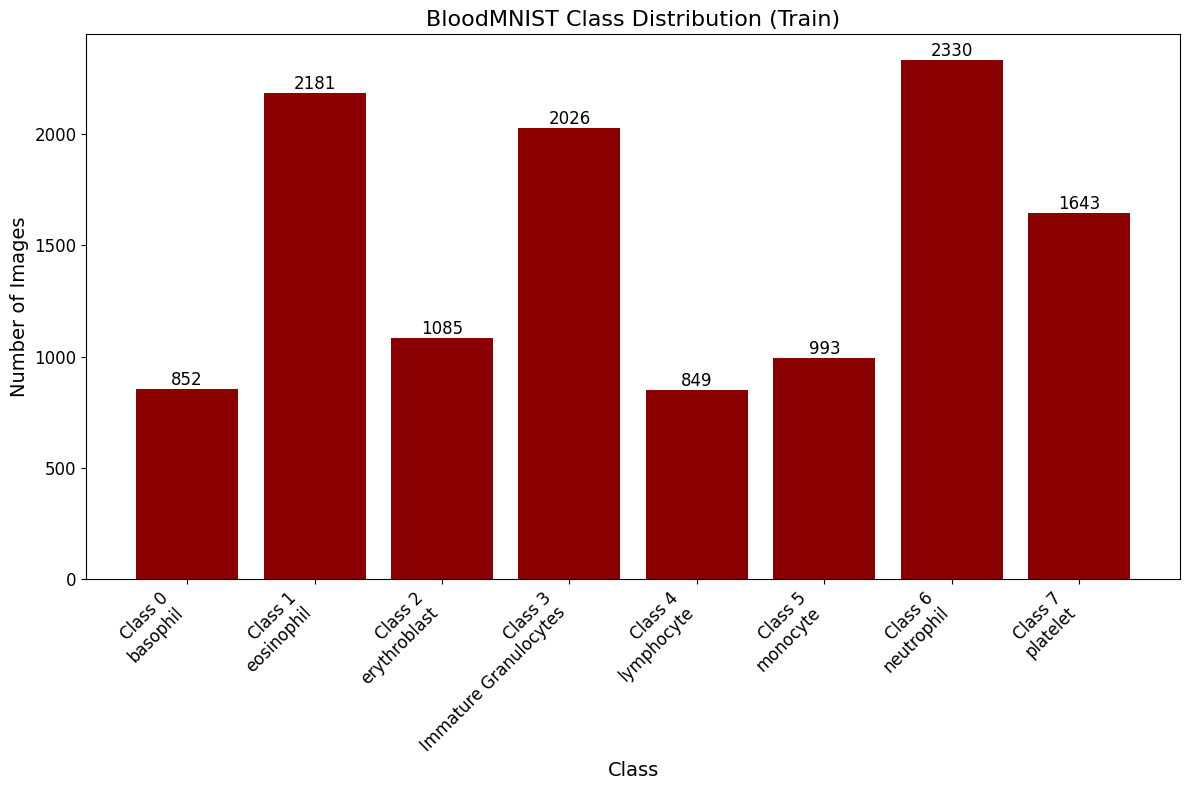

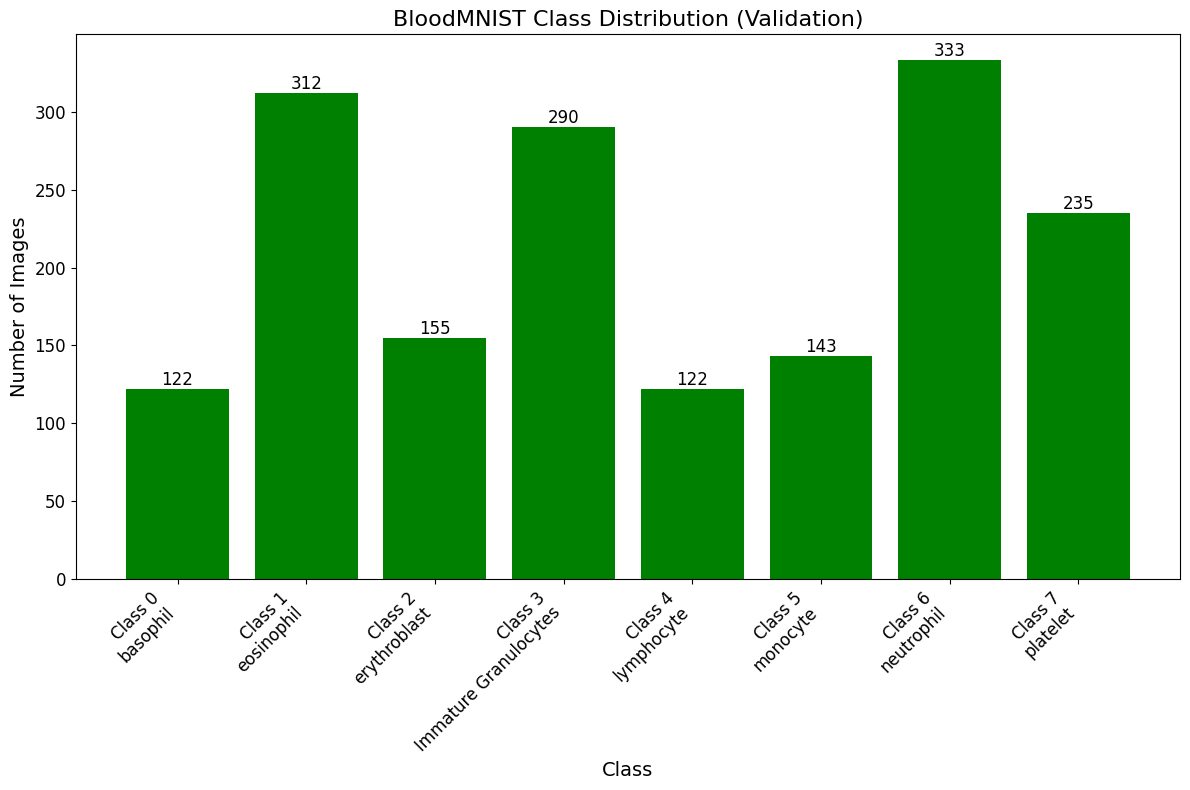

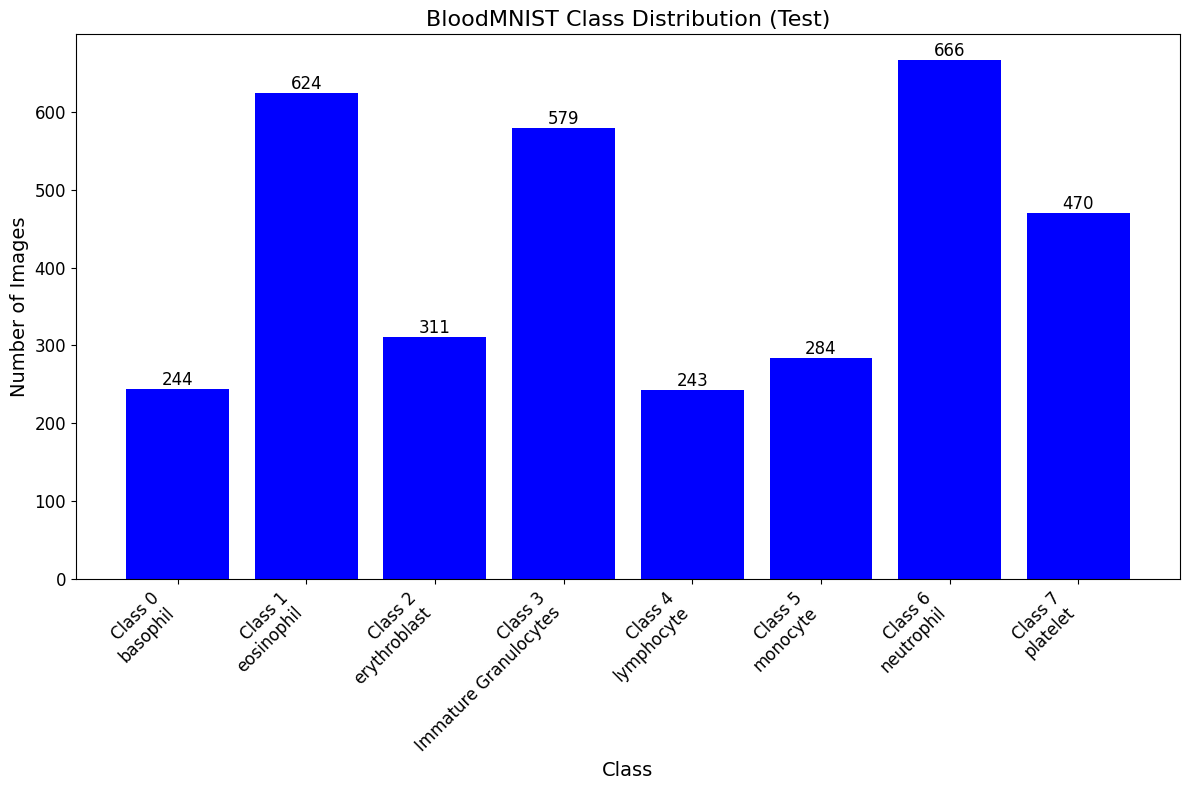

In [7]:
# Count the number of instances for each class in each split
label_counts_train = Counter([int(label) for _, label in train_data])
label_counts_val = Counter([int(label) for _, label in val_data])
label_counts_test = Counter([int(label) for _, label in test_data])

def plot_class_distribution(label_counts, class_labels, title, color):
    classes = list(range(len(class_labels)))  # Ensure all classes are shown
    counts = [label_counts.get(i, 0) for i in classes]
    labels = [f"Class {i}\n{class_labels[str(i)]}" for i in classes]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(classes, counts, tick_label=labels, color=color)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Add data labels on top of each column
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

# Plot BloodMNIST class distribution
plot_class_distribution(label_counts_train, class_labels_blood, 'BloodMNIST Class Distribution (Train)', 'darkred')
plot_class_distribution(label_counts_val, class_labels_blood, 'BloodMNIST Class Distribution (Validation)', 'green')
plot_class_distribution(label_counts_test, class_labels_blood, 'BloodMNIST Class Distribution (Test)', 'blue')


# Image Preprocessing

- **Binary Thresholding**: Convert images to grayscale and apply a binary threshold to segment the target cells. This step helps in isolating the cells from the background by converting the image to black and white based on a threshold value.

- **Noise Reduction**: Remove small objects from the binary image to focus on the most significant parts of the image (i.e., target cells)

- **Component Labeling**: Label connected components in the binary image and retain the largest connected component, assuming it's the target cell. This step ensures that only the most relevant part of the image is considered.

- **Masking**: Apply the binary mask to the original image to highlight the target cells while suppressing the background and other irrelevant objects.

- **Data Conversion**: Use a class to convert the preprocessed data back to the original data format, which maintains compatibility with PyTorch methods while preserving the data structure for model training and evaluation.


In [8]:
def preprocess_image(image):
    # Convert to grayscale
    gray = rgb2gray(image)

    # Apply a binary threshold to segment the target cells
    _, binary = cv2.threshold((gray * 255).astype(np.uint8), 128, 255, cv2.THRESH_BINARY_INV)

    # Remove small objects from the binary image
    cleaned = morphology.remove_small_objects(binary > 0, min_size=500)

    # Label the connected components
    labeled, num_labels = measure.label(cleaned, return_num=True, connectivity=2)

    # Keep the largest connected component (assuming it's the target cell)
    largest_component = morphology.remove_small_objects(labeled, min_size=500)

    # Mask the original image
    masked_image = image * np.dstack([largest_component > 0] * 3)

    return masked_image

In [9]:
def show_comparison(dataset, n_images=5):
    """Show comparison of original image to preprocessed image"""
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

    for i in range(n_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        preprocessed_img = preprocess_image(np.array(img))

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original Image - Class {int(label)}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(preprocessed_img)
        axes[i, 1].set_title(f"Preprocessed Image - Class {int(label)}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
def preprocess_dataset(dataset):
    """Pre-process the entire dataset"""
    preprocessed_data = []
    for img, label in dataset:
        preprocessed_img = preprocess_image(np.array(img))
        preprocessed_data.append((preprocessed_img, label))
    return preprocessed_data

In [11]:
# # Preprocess and overwrite the datasets
# # Run once then comment out and run pickle.load below

# train_data_preprocessed = preprocess_dataset(train_data)
# val_data_preprocessed = preprocess_dataset(val_data)
# test_data_preprocessed = preprocess_dataset(test_data)

# # Save the preprocessed datasets to disk
# with open('pickle/train_data_preprocessed.pkl', 'wb') as f:
#     pickle.dump(train_data_preprocessed, f)
# with open('pickle/val_data_preprocessed.pkl', 'wb') as f:
#     pickle.dump(val_data_preprocessed, f)
# with open('pickle/test_data_preprocessed.pkl', 'wb') as f:
#     pickle.dump(test_data_preprocessed, f)


In [12]:
with open('pickle/train_data_preprocessed.pkl', 'rb') as f:
    train_data_preprocessed = pickle.load(f)
with open('pickle/val_data_preprocessed.pkl', 'rb') as f:
    val_data_preprocessed = pickle.load(f)
with open('pickle/test_data_preprocessed.pkl', 'rb') as f:
    test_data_preprocessed = pickle.load(f)

In [13]:
# Convert preprocessed data back to original data format
class PreprocessedDataset:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        img, label = self.data[index]
        return img, label

    def __len__(self):
        return len(self.data)

In [14]:
# # Run once then comment out and run pickle.load below

# # Create dataset objects
# train_data_preprocessed = PreprocessedDataset(train_data_preprocessed)
# val_data_preprocessed = PreprocessedDataset(val_data_preprocessed)
# test_data_preprocessed = PreprocessedDataset(test_data_preprocessed)

# with open('pickle/train_data_preprocessed_dataset.pkl', 'wb') as f:
#     pickle.dump(train_data_preprocessed, f)
# with open('pickle/val_data_preprocessed_dataset.pkl', 'wb') as f:
#     pickle.dump(val_data_preprocessed, f)
# with open('pickle/test_data_preprocessed_dataset.pkl', 'wb') as f:
#     pickle.dump(test_data_preprocessed, f)

In [15]:
with open('pickle/train_data_preprocessed_dataset.pkl', 'rb') as f:
    train_data_preprocessed = pickle.load(f)
with open('pickle/val_data_preprocessed_dataset.pkl', 'rb') as f:
    val_data_preprocessed = pickle.load(f)
with open('pickle/test_data_preprocessed_dataset.pkl', 'rb') as f:
    test_data_preprocessed = pickle.load(f)

# Display Images

C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\3491637420.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


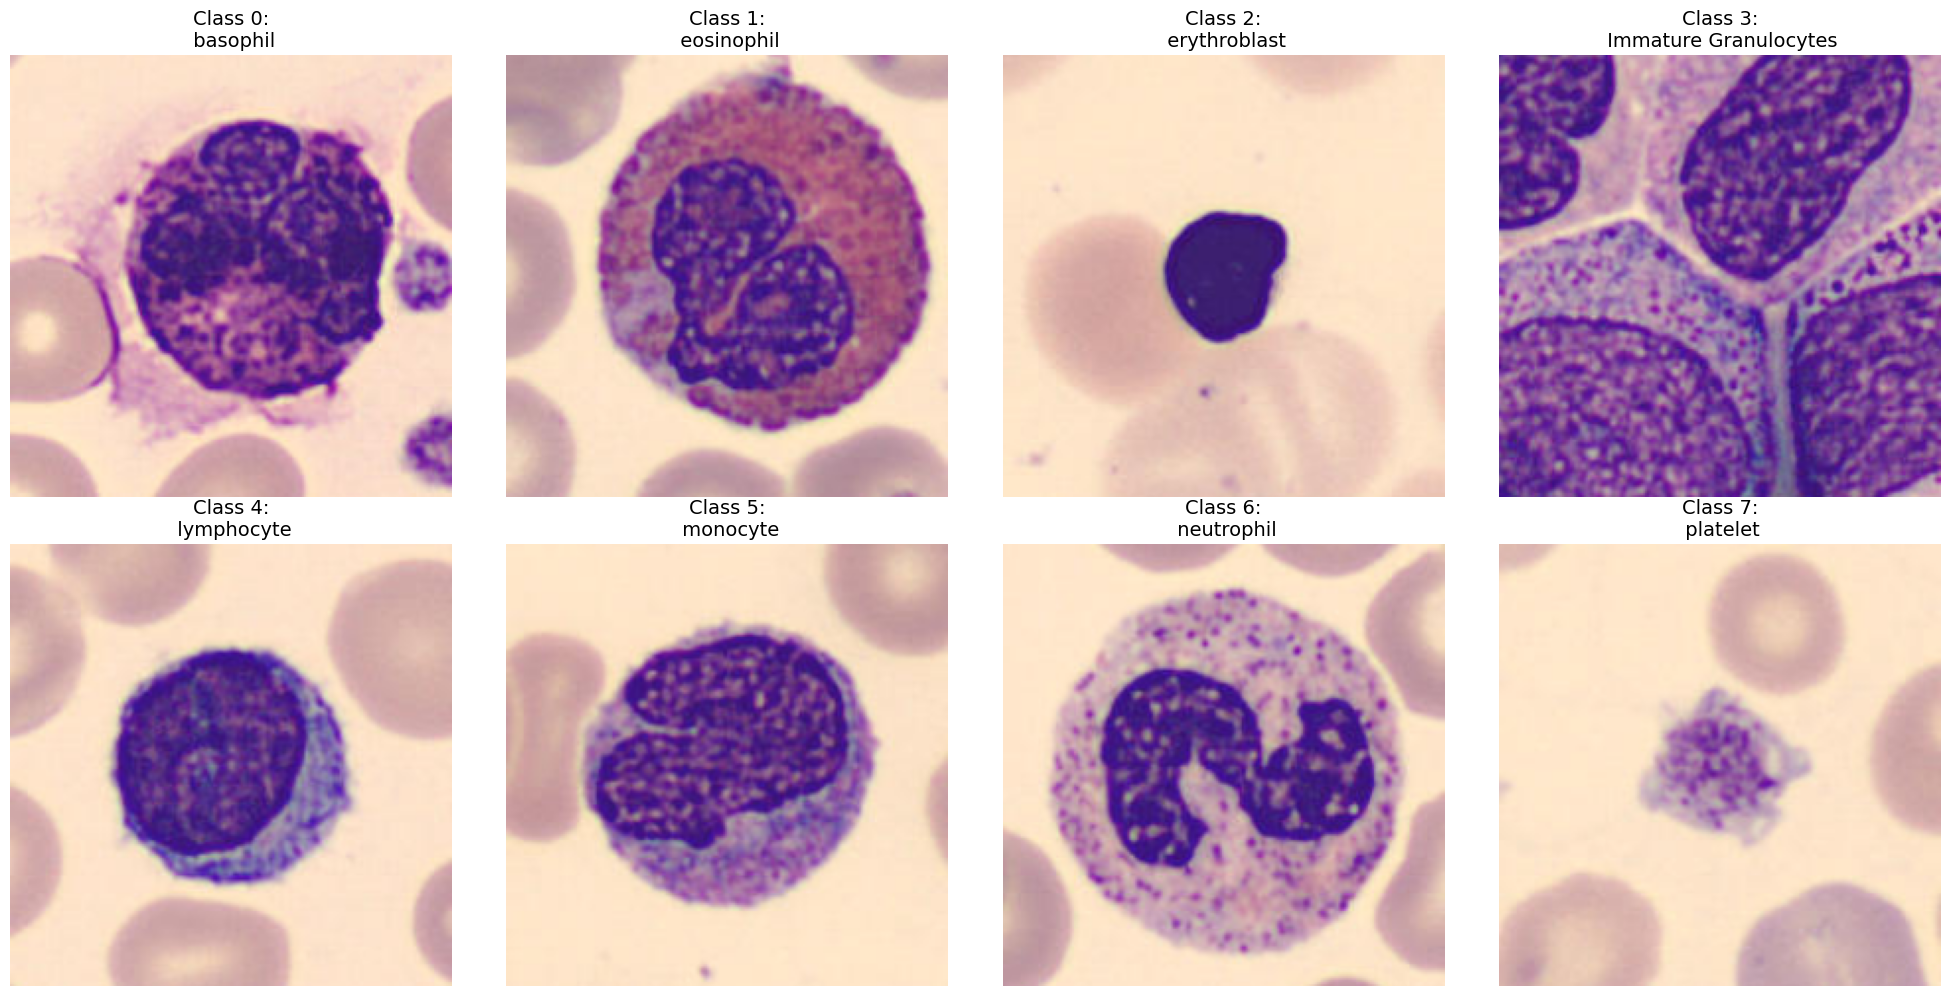

In [16]:
def show_one_image_per_class(dataset, n_classes, class_labels):
    """Randomly show one pre-processed image per class"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            axes[class_idx].imshow(random_img)
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Show one example image from the preprocessed training dataset for each class
show_one_image_per_class(train_data, n_classes_blood, class_labels_blood)

C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\2859168895.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)
C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\3076591847.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[i, 0].set_title(f"Original Image - Class {int(label)}")
C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\3076591847.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[i, 1].set_title(f"Preprocessed Image - Class {int(label)}")


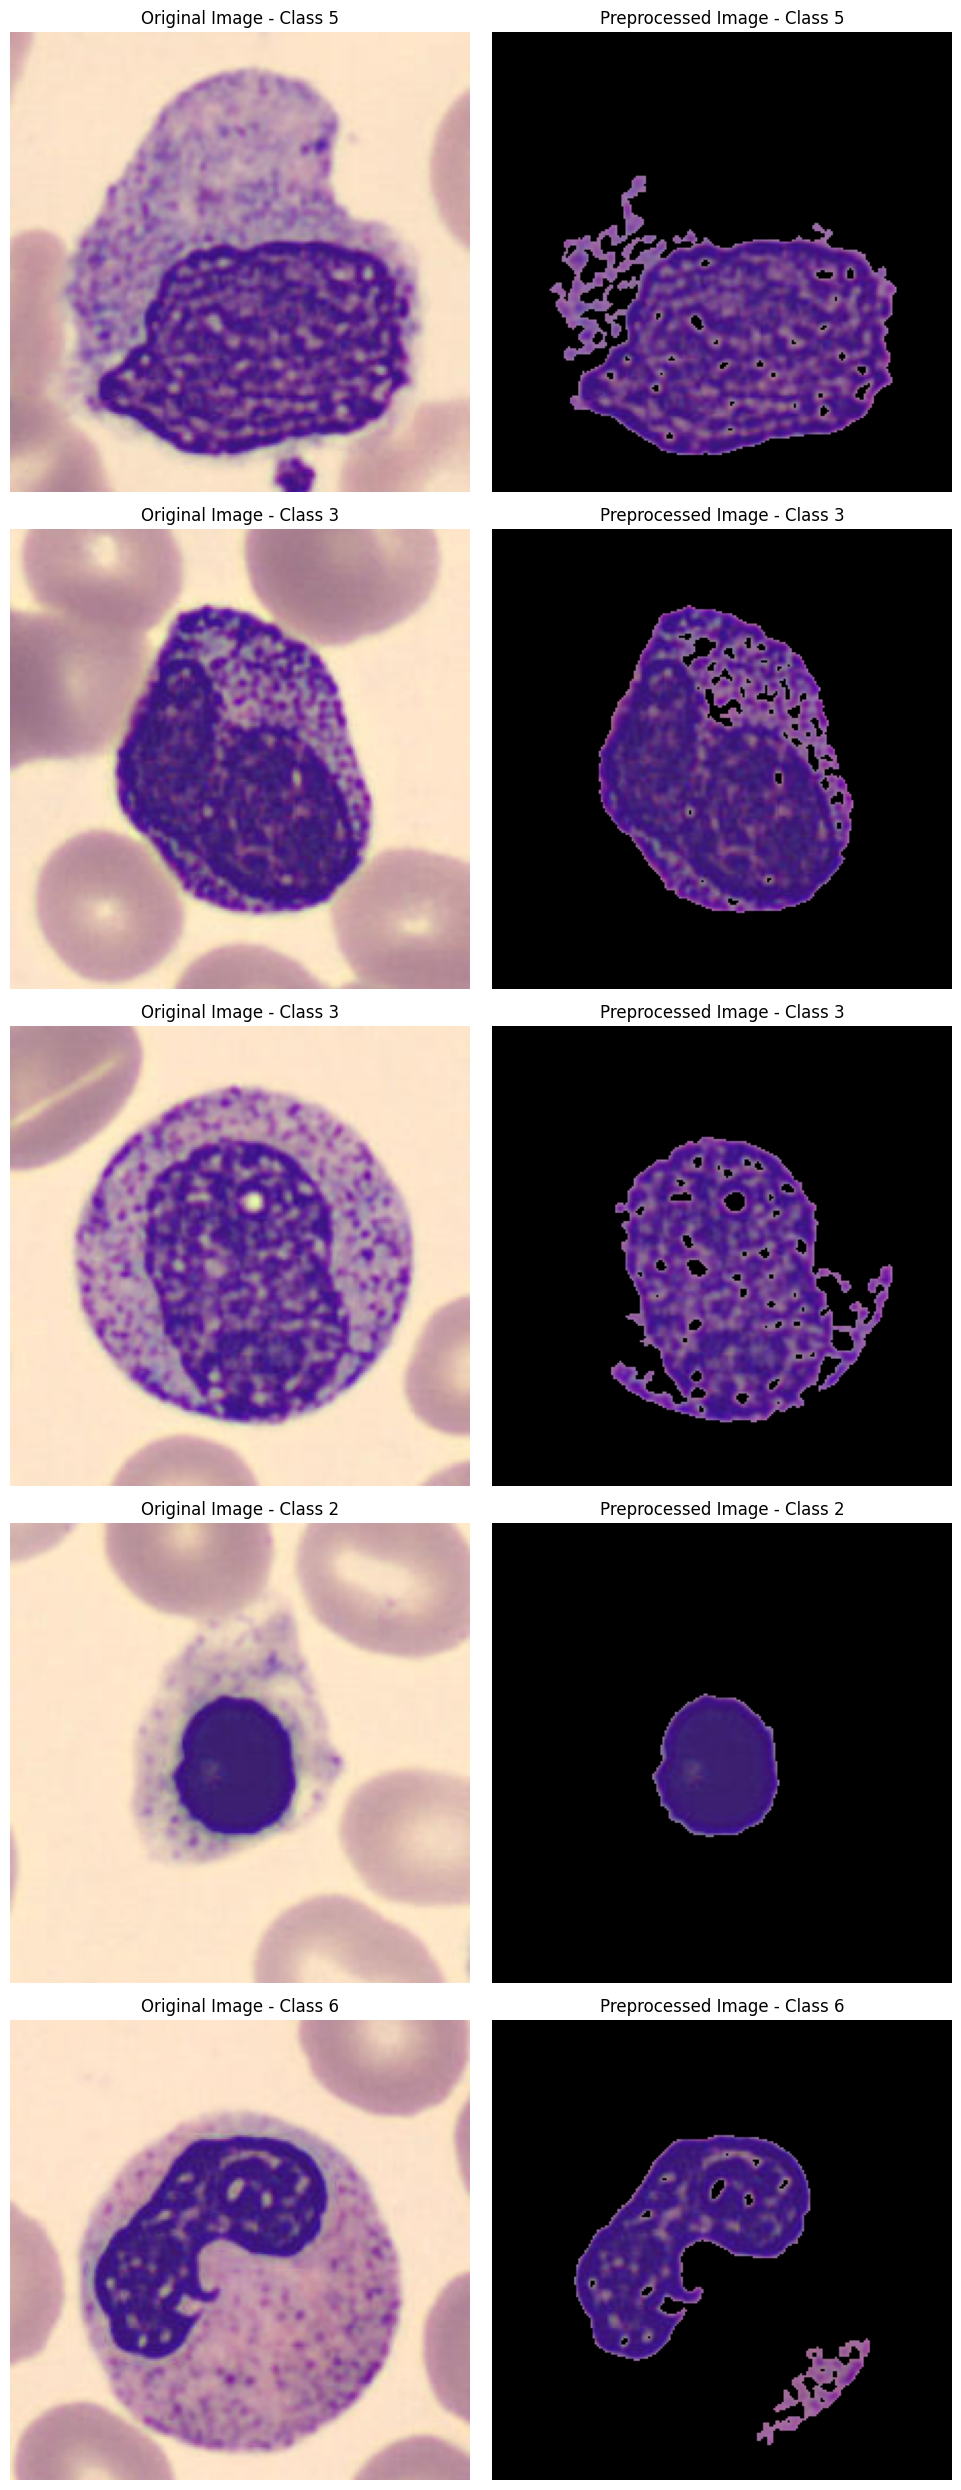

In [17]:
# Show comparison for 5 random images from the training dataset to showcase the pre-processing transformations
show_comparison(train_data, n_images=5)

# Feature Engineering
- Simple Feature: Edges
    - Edge detection can highlight the boundaries of cells, which is crucial for distinguishing between different types of blood cells based on their shape and size. Using edge detection algorithms can provide valuable information about cell morphology.

- Simple Feature: Color Histograms
    - Color histograms represent the distribution of colors in an image and can help differentiate between cell types based on color variations. This is particularly useful for identifying cell types like eosinophils and basophils, which have distinct color characteristics.

- Complex Feature: Texture Analysis
    - Texture analysis involves examining the surface characteristics of cells, which can be quantified using methods like Local Binary Patterns (LBP) or Gray Level Co-occurrence Matrix (GLCM). Texture features can provide deeper insights into the cell structure, helping to distinguish between similar looking cell types.


## Create Function for Feature Vector

In [18]:
def create_feature_vectors(dataset, feature_extractors):
    feature_vectors = []
    labels = []
    for img, label in dataset:
        features = []
        for extractor in feature_extractors:
            features.extend(extractor(np.array(img)))
        feature_vectors.append(features)
        labels.append(label)
    return np.array(feature_vectors), np.array(labels)


## Edge Detection

In [19]:
def extract_edge_features(image):
    edges = cv2.Canny((rgb2gray(image) * 255).astype(np.uint8), 100, 200)
    return edges.flatten()

C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\3218036915.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)
C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\2859168895.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


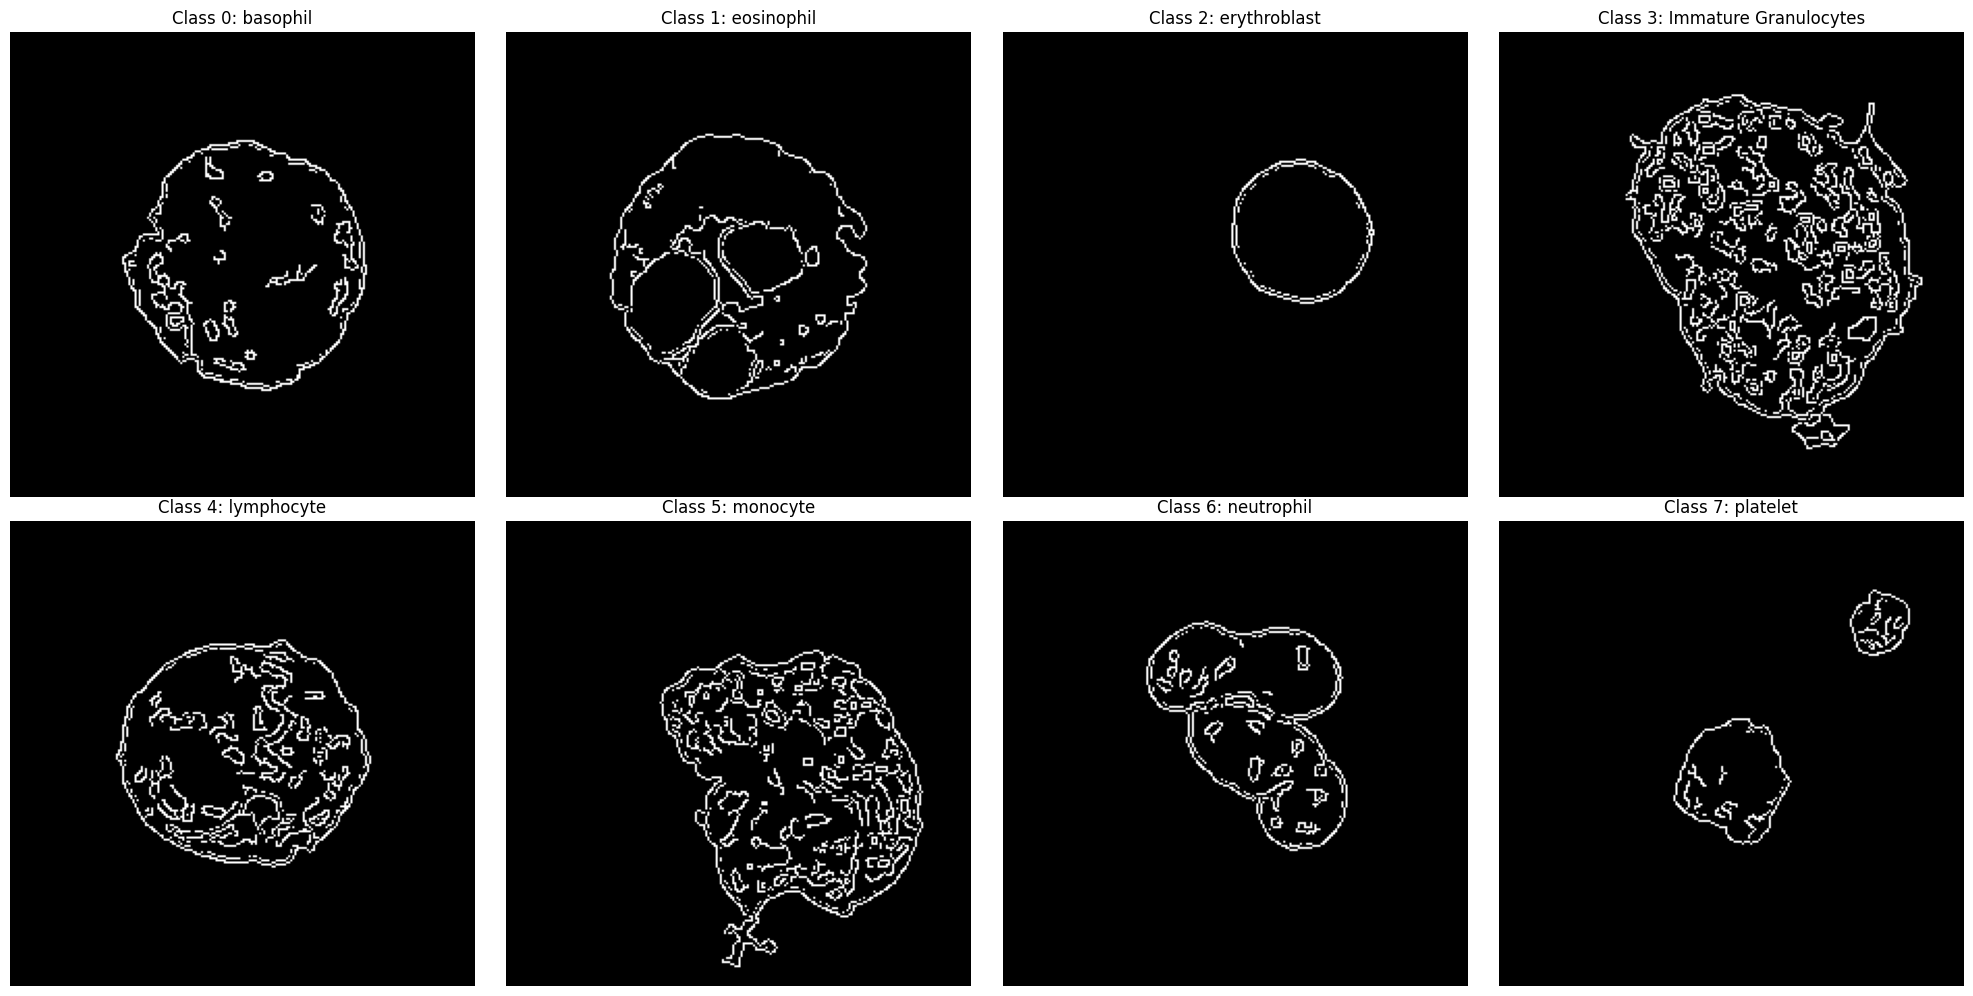

In [20]:
def show_edge_detection_per_class(dataset, n_classes, class_labels):
    """Show edge detection results for one example per class"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        if len(class_images[label]) < 1:  # Store one example per class
            class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            img = class_images[class_idx][0]
            preprocessed_img = preprocess_image(np.array(img))
            edges = cv2.Canny((rgb2gray(img) * 255).astype(np.uint8), 100, 200)

            axes[class_idx].imshow(edges, cmap='gray')
            axes[class_idx].set_title(f"Class {class_idx}: {class_labels[str(class_idx)]}")
            axes[class_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Show edge detection for one example from each class
show_edge_detection_per_class(train_data_preprocessed, n_classes_blood, class_labels_blood)


## Color Histograms

In [21]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    # Convert PIL Image to NumPy array
    image = np.array(image)

    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Compute the color histogram
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])

    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()

    return hist

C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\3624279311.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


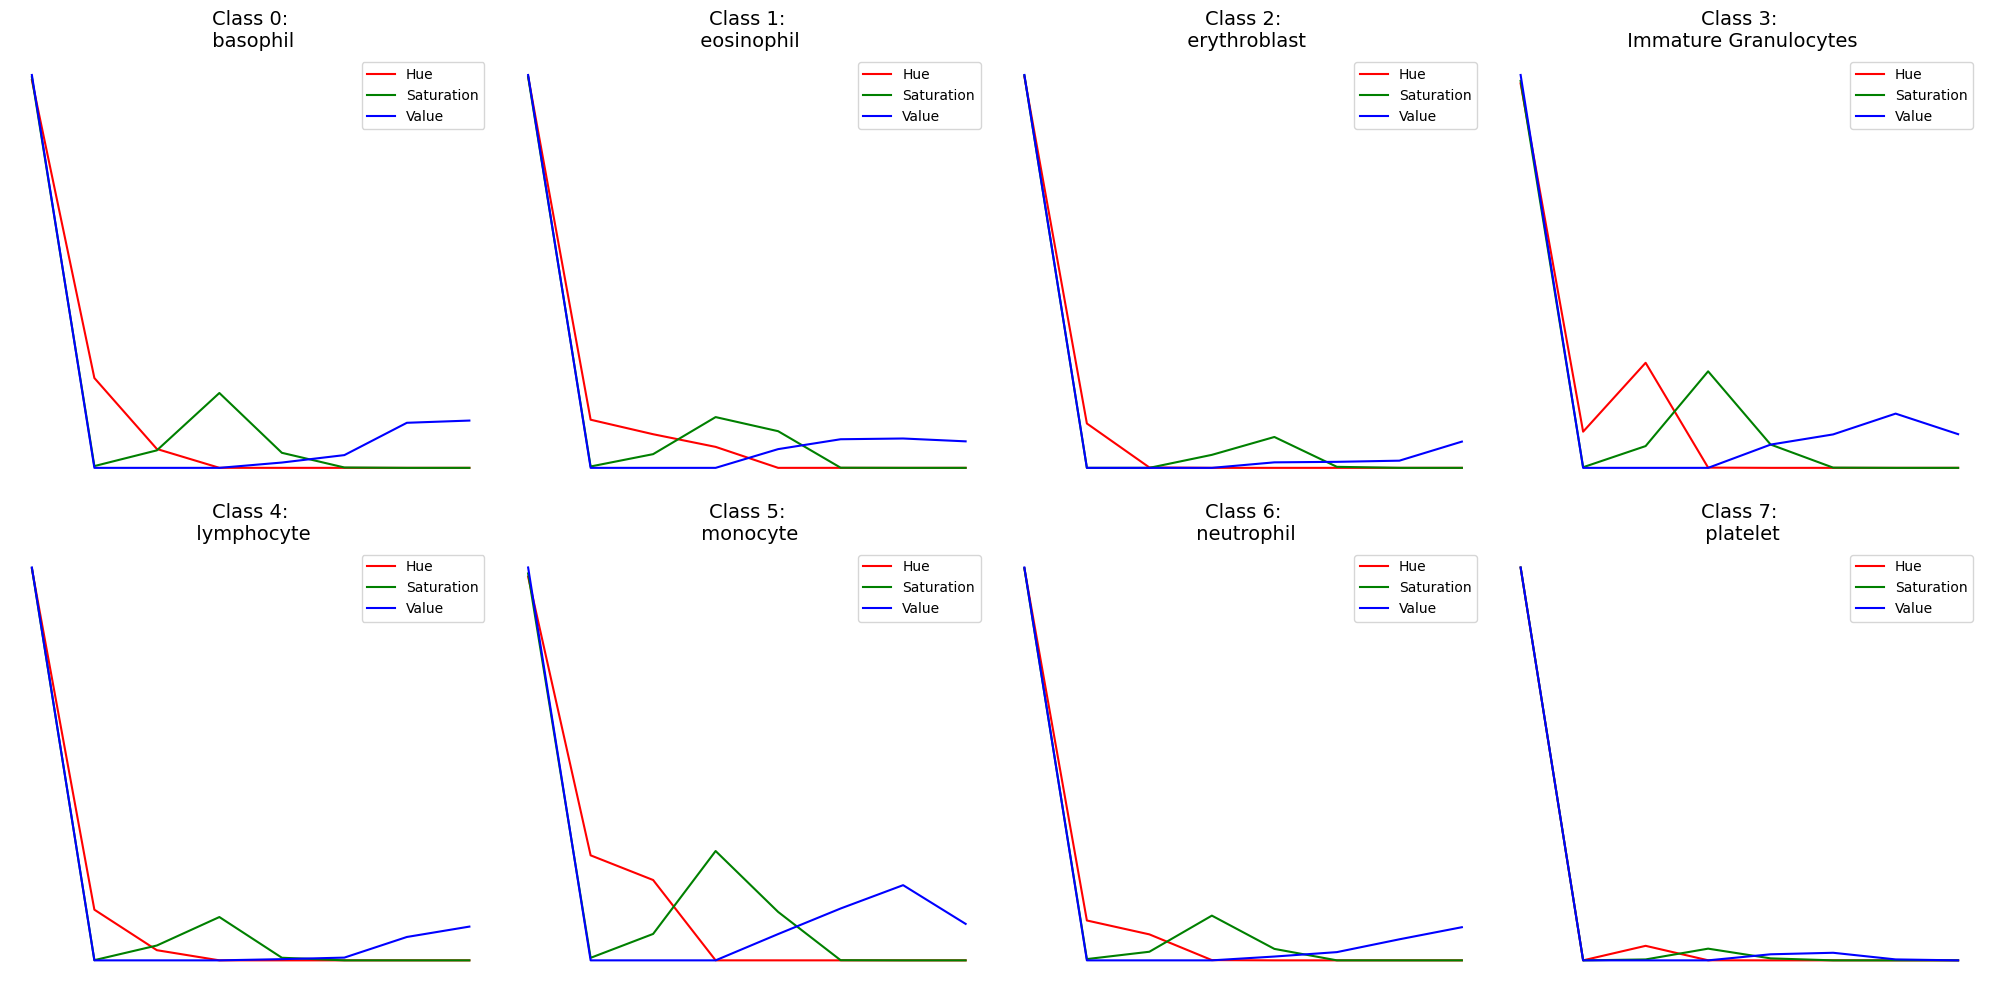

In [22]:
def show_color_histograms(dataset, n_classes, class_labels, bins=(8, 8, 8)):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            hsv = cv2.cvtColor((random_img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)

            # Compute the histograms for each channel
            hist_hue = cv2.calcHist([hsv], [0], None, [bins[0]], [0, 180])
            hist_saturation = cv2.calcHist([hsv], [1], None, [bins[1]], [0, 256])
            hist_value = cv2.calcHist([hsv], [2], None, [bins[2]], [0, 256])

            # Normalize the histograms
            hist_hue = cv2.normalize(hist_hue, hist_hue).flatten()
            hist_saturation = cv2.normalize(hist_saturation, hist_saturation).flatten()
            hist_value = cv2.normalize(hist_value, hist_value).flatten()

            # Plot histograms
            axes[class_idx].plot(hist_hue, color='r', label='Hue')
            axes[class_idx].plot(hist_saturation, color='g', label='Saturation')
            axes[class_idx].plot(hist_value, color='b', label='Value')
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')
            axes[class_idx].legend()

    plt.tight_layout()
    plt.show()

# Show color histograms for each class
show_color_histograms(train_data_preprocessed, n_classes_blood, class_labels_blood)


## Colored Pixel Count

In [23]:
# Pickle path for the final result
pickle_path = os.path.join(PICKLE_DIR, 'stain_counts.pkl')

# Check if the pickled file exists
if os.path.exists(pickle_path):
    with open(pickle_path, 'rb') as f:
        stain_counts_df = pickle.load(f)
else:
    stain_counts_df = pd.DataFrame(columns=['class', 'stained_cell_count'])

    # Optimized function to count stained cell pixels using vectorized operations
    def count_stained_cell_pixs(new_im, red_range, gre_range, blu_range):
        r_min, r_max = red_range
        g_min, g_max = gre_range
        b_min, b_max = blu_range
        
        red_mask = (new_im[:, :, 0] >= r_min) & (new_im[:, :, 0] <= r_max)
        green_mask = (new_im[:, :, 1] >= g_min) & (new_im[:, :, 1] <= g_max)
        blue_mask = (new_im[:, :, 2] >= b_min) & (new_im[:, :, 2] <= b_max)
        
        stained_mask = red_mask & green_mask & blue_mask
        
        return np.sum(stained_mask)

    # Define pixel value ranges to search
    red_range_d = (66, 150)
    gre_range_d = (10, 66)
    blu_range_d = (123, 142)

    red_range_l = (151, 192)
    gre_range_l = (67, 154)
    blu_range_l = (143, 162)

    # Function to iterate through examples
    def process_data(data, red_range_d, gre_range_d, blu_range_d, red_range_l, gre_range_l, blu_range_l, start_idx=0):
        num = len(data)
        results = pd.DataFrame(columns=['class', 'stained_cell_count', 'light_stain_count'])
        
        for i in range(num):
            im, label = data[i]
            im_array = np.array(im)

            cell_pix_count_d = count_stained_cell_pixs(im_array, red_range_d, gre_range_d, blu_range_d)
            cell_pix_count_l = count_stained_cell_pixs(im_array, red_range_l, gre_range_l, blu_range_l)
            
            class_label = "class" + str(label[0])
            results.loc[start_idx + i] = [class_label, cell_pix_count_d, cell_pix_count_l]
        
        return results

    # Process each dataset
    stain_counts_df_train = process_data(train_data_preprocessed, red_range_d, gre_range_d, blu_range_d, red_range_l, gre_range_l, blu_range_l, start_idx=0)
    stain_counts_df_val = process_data(val_data_preprocessed, red_range_d, gre_range_d, blu_range_d, red_range_l, gre_range_l, blu_range_l, start_idx=len(train_data_preprocessed))
    stain_counts_df_test = process_data(test_data_preprocessed, red_range_d, gre_range_d, blu_range_d, red_range_l, gre_range_l, blu_range_l, start_idx=len(train_data_preprocessed) + len(val_data_preprocessed))

    # Concatenate the results
    stain_counts_df = pd.concat([stain_counts_df_train, stain_counts_df_val, stain_counts_df_test], ignore_index=True)

    # Save the final result to a pickle file
    with open(pickle_path, 'wb') as f:
        pickle.dump(stain_counts_df, f)

print(len(stain_counts_df))
stain_counts_df

17092


class  stained_cell_count  light_stain_count
0      class7                 782                 55
1      class3                6188                105
2      class6                2785                 68
3      class6                4575                122
4      class7                 284                209
...       ...                 ...                ...
17087  class6                3196                 32
17088  class3                4345                760
17089  class3                3686                589
17090  class1                1479               2155
17091  class7                 552                  1

[17092 rows x 3 columns]

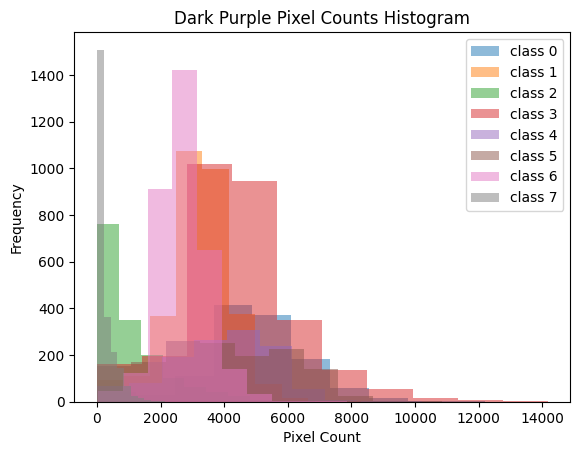

In [24]:
# dark purple stain histogram
cl_0_d = stain_counts_df[stain_counts_df['class']== 'class0']['stained_cell_count']
cl_1_d = stain_counts_df[stain_counts_df['class']== 'class1']['stained_cell_count']
cl_2_d = stain_counts_df[stain_counts_df['class']== 'class2']['stained_cell_count']
cl_3_d = stain_counts_df[stain_counts_df['class']== 'class3']['stained_cell_count']
cl_4_d = stain_counts_df[stain_counts_df['class']== 'class4']['stained_cell_count']
cl_5_d = stain_counts_df[stain_counts_df['class']== 'class5']['stained_cell_count']
cl_6_d = stain_counts_df[stain_counts_df['class']== 'class6']['stained_cell_count']
cl_7_d = stain_counts_df[stain_counts_df['class']== 'class7']['stained_cell_count']

plt.hist(cl_0_d,  alpha=0.5, label='class 0')
plt.hist(cl_1_d,  alpha=0.5, label='class 1')
plt.hist(cl_2_d,  alpha=0.5, label='class 2')
plt.hist(cl_3_d,  alpha=0.5, label='class 3')
plt.hist(cl_4_d,  alpha=0.5, label='class 4')
plt.hist(cl_5_d,  alpha=0.5, label='class 5')
plt.hist(cl_6_d,  alpha=0.5, label='class 6')
plt.hist(cl_7_d,  alpha=0.5, label='class 7')

plt.title('Dark Purple Pixel Counts Histogram')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

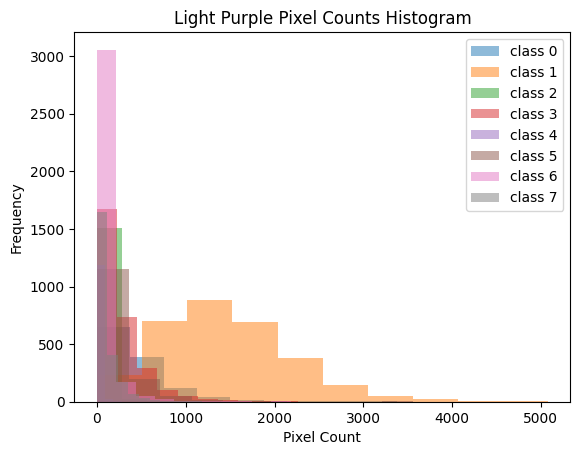

In [25]:
# light purple stain histogram
cl_0_l = stain_counts_df[stain_counts_df['class']== 'class0']['light_stain_count']
cl_1_l = stain_counts_df[stain_counts_df['class']== 'class1']['light_stain_count']
cl_2_l = stain_counts_df[stain_counts_df['class']== 'class2']['light_stain_count']
cl_3_l = stain_counts_df[stain_counts_df['class']== 'class3']['light_stain_count']
cl_4_l = stain_counts_df[stain_counts_df['class']== 'class4']['light_stain_count']
cl_5_l = stain_counts_df[stain_counts_df['class']== 'class5']['light_stain_count']
cl_6_l = stain_counts_df[stain_counts_df['class']== 'class6']['light_stain_count']
cl_7_l = stain_counts_df[stain_counts_df['class']== 'class7']['light_stain_count']

plt.hist(cl_0_l,  alpha=0.5, label='class 0')
plt.hist(cl_1_l,  alpha=0.5, label='class 1')
plt.hist(cl_2_l,  alpha=0.5, label='class 2')
plt.hist(cl_3_l,  alpha=0.5, label='class 3')
plt.hist(cl_4_l,  alpha=0.5, label='class 4')
plt.hist(cl_5_l,  alpha=0.5, label='class 5')
plt.hist(cl_6_l,  alpha=0.5, label='class 6')
plt.hist(cl_7_l,  alpha=0.5, label='class 7')

plt.title('Light Purple Pixel Counts Histogram')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [26]:
# averages of values by class w/ ratio of dark to light pixel counts
averages_df  = pd.DataFrame(columns = ['class', 'dark_stain_avg', 'light_stain_avg', 'ratio'])

averages_df.loc[0] = ['class0', cl_0_d.mean(), cl_0_l.mean(), cl_0_d.mean()/cl_0_l.mean()]
averages_df.loc[1] = ['class1', cl_1_d.mean(), cl_1_l.mean(), cl_1_d.mean()/cl_1_l.mean()]
averages_df.loc[2] = ['class2', cl_2_d.mean(), cl_2_l.mean(), cl_2_d.mean()/cl_2_l.mean()]
averages_df.loc[3] = ['class3', cl_3_d.mean(), cl_3_l.mean(), cl_3_d.mean()/cl_3_l.mean()]
averages_df.loc[4] = ['class4', cl_4_d.mean(), cl_4_l.mean(), cl_4_d.mean()/cl_4_l.mean()]
averages_df.loc[5] = ['class5', cl_5_d.mean(), cl_5_l.mean(), cl_5_d.mean()/cl_5_l.mean()]
averages_df.loc[6] = ['class6', cl_6_d.mean(), cl_6_l.mean(), cl_6_d.mean()/cl_6_l.mean()]
averages_df.loc[7] = ['class7', cl_7_d.mean(), cl_7_l.mean(), cl_7_d.mean()/cl_7_l.mean()]


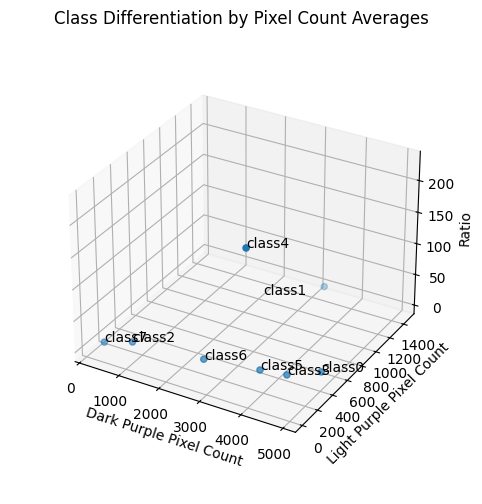

In [27]:
# scatterplot on 3d axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(averages_df['dark_stain_avg'], averages_df['light_stain_avg'], averages_df['ratio'])

# class_labels = stain_counts_df['class']
# for i in range(len(class_labels)):
#     ax.annotate(class_labels[i], (averages_df.loc[i]['dark_stain_avg'], averages_df.loc[i]['light_stain_avg'], averages_df.loc[i]['ratio']))

# for i in averages_df.index:
ax.text(averages_df.loc[0]['dark_stain_avg'], averages_df.loc[0]['light_stain_avg'], averages_df.loc[0]['ratio'], averages_df.loc[0]['class'])
ax.text(averages_df.loc[1]['dark_stain_avg']-1000, averages_df.loc[1]['light_stain_avg']-300, averages_df.loc[1]['ratio'], averages_df.loc[1]['class'])
ax.text(averages_df.loc[2]['dark_stain_avg'], averages_df.loc[2]['light_stain_avg'], averages_df.loc[2]['ratio'], averages_df.loc[2]['class'])
ax.text(averages_df.loc[3]['dark_stain_avg'], averages_df.loc[3]['light_stain_avg'], averages_df.loc[3]['ratio'], averages_df.loc[3]['class'])
ax.text(averages_df.loc[4]['dark_stain_avg'], averages_df.loc[4]['light_stain_avg'], averages_df.loc[4]['ratio']+0.05, averages_df.loc[4]['class'])
ax.text(averages_df.loc[5]['dark_stain_avg'], averages_df.loc[5]['light_stain_avg'], averages_df.loc[5]['ratio']-0.1, averages_df.loc[5]['class'])
ax.text(averages_df.loc[6]['dark_stain_avg'], averages_df.loc[6]['light_stain_avg'], averages_df.loc[6]['ratio'], averages_df.loc[6]['class'])
ax.text(averages_df.loc[7]['dark_stain_avg'], averages_df.loc[7]['light_stain_avg'], averages_df.loc[7]['ratio'], averages_df.loc[7]['class'])

ax.set_title('Class Differentiation by Pixel Count Averages')
ax.set_xlabel('Dark Purple Pixel Count')
ax.set_ylabel('Light Purple Pixel Count')
ax.set_zlabel('Ratio')
ax.set_box_aspect(aspect=None, zoom=0.85)
plt.show()

In [28]:
# Create ratio of light:dark cell counts
stain_counts_df['light_to_dark_ratio'] = stain_counts_df['light_stain_count'] / stain_counts_df['stained_cell_count']

In [29]:
stain_counts_df['light_to_dark_ratio']

0        0.070332
1        0.016968
2        0.024417
3        0.026667
4        0.735915
           ...   
17087    0.010013
17088    0.174914
17089    0.159794
17090    1.457066
17091    0.001812
Name: light_to_dark_ratio, Length: 17092, dtype: float64

In [30]:
# stain_counts_df.to_csv('stained_counts_featuer_train_val_test.csv')

# Initialize t-SNE Function

In [31]:
from sklearn.manifold import TSNE

# Directory for pickling
PICKLE_DIR = 'pickle'
os.makedirs(PICKLE_DIR, exist_ok=True)

# Function to perform t-SNE and save the results to a pickle file
def perform_tsne_and_pickle(features, labels, title, pickle_path):
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as f:
            tsne_results = pickle.load(f)
        print(f"Loaded t-SNE results from {pickle_path}")
    else:
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(features)
        with open(pickle_path, 'wb') as f:
            pickle.dump(tsne_results, f)
        print(f"Saved t-SNE results to {pickle_path}")
    
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=labels.flatten().astype(int),
        palette=sns.color_palette("hsv", len(set(labels.flatten().astype(int)))),
        legend="full",
        alpha=0.6
    )
    plt.title(title)
    plt.show()

## Edge Detection & PCA

In [32]:
# # Create feature vectors using the specified features
# # Run once then comment out and run pickle.load below

# X_train, y_train = create_feature_vectors(train_data_preprocessed, [extract_edge_features])
# X_val, y_val = create_feature_vectors(val_data_preprocessed, [extract_edge_features])
# X_test, y_test = create_feature_vectors(test_data_preprocessed, [extract_edge_features])

# # Save the feature vectors and labels to disk
# with open('pickle/X_train_edge.pkl', 'wb') as f:
#     pickle.dump(X_train, f)
# with open('pickle/y_train_edge.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('pickle/X_val_edge.pkl', 'wb') as f:
#     pickle.dump(X_val, f)
# with open('pickle/y_val_edge.pkl', 'wb') as f:
#     pickle.dump(y_val, f)
# with open('pickle/X_test_edge.pkl', 'wb') as f:
#     pickle.dump(X_test, f)
# with open('pickle/y_test_edge.pkl', 'wb') as f:
#     pickle.dump(y_test, f)


In [33]:
with open('pickle/X_train_edge.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('pickle/y_train_edge.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('pickle/X_val_edge.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('pickle/y_val_edge.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('pickle/X_test_edge.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('pickle/y_test_edge.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [34]:
# # Apply PCA to reduce dimensionality
# # Run once then comment out and run pickle.load below
# n_components = 100  # Adjust based on trade-off between speed and explained variance
# pca = PCA(n_components=n_components)
# X_train_pca = pca.fit_transform(X_train)
# X_val_pca = pca.transform(X_val)
# X_test_pca = pca.transform(X_test)

# # Save the PCA object and transformed feature vectors to disk
# with open('pickle/pca.pkl', 'wb') as f:
#     pickle.dump(pca, f)
# with open('pickle/X_train_edge_pca.pkl', 'wb') as f:
#     pickle.dump(X_train_pca, f)
# with open('pickle/X_val_edge_pca.pkl', 'wb') as f:
#     pickle.dump(X_val_pca, f)
# with open('pickle/X_test_edge_pca.pkl', 'wb') as f:
#     pickle.dump(X_test_pca, f)

In [35]:
n_components = 100  # Adjust based on trade-off between speed and explained variance
pca = PCA(n_components=n_components)

with open('pickle/pca.pkl', 'rb') as f:
    pca = pickle.load(f)
with open('pickle/X_train_edge_pca.pkl', 'rb') as f:
    X_train_pca = pickle.load(f)
with open('pickle/X_val_edge_pca.pkl', 'rb') as f:
    X_val_pca = pickle.load(f)
with open('pickle/X_test_edge_pca.pkl', 'rb') as f:
    X_test_pca = pickle.load(f)

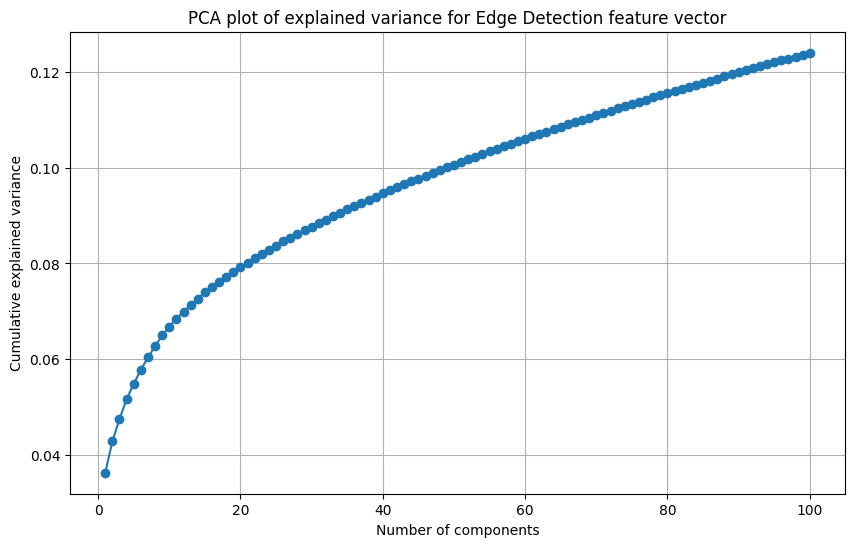

In [36]:
# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for Edge Detection feature vector')
plt.grid(True)
plt.show()

Loaded t-SNE results from pickle\edge_tsne.pkl


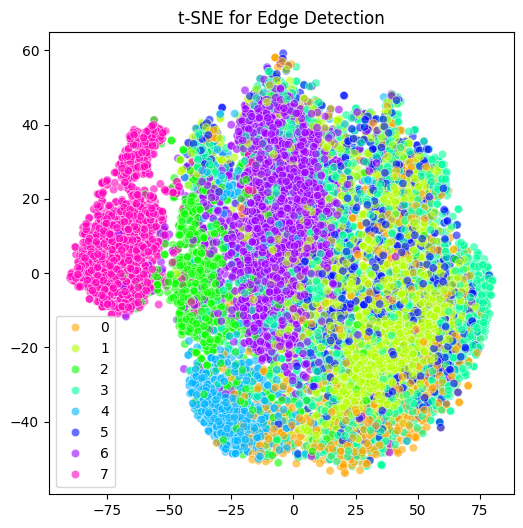

In [37]:
edge_tsne = os.path.join(PICKLE_DIR, 'edge_tsne.pkl')
perform_tsne_and_pickle(X_train_pca, y_train, title='t-SNE for Edge Detection', pickle_path=edge_tsne)

## Color Histograms and PCA

In [38]:
X_train, y_train = create_feature_vectors(train_data_preprocessed, [extract_color_histogram])
X_val, y_val = create_feature_vectors(val_data_preprocessed, [extract_color_histogram])
X_test, y_test = create_feature_vectors(test_data_preprocessed, [extract_color_histogram])

# Apply PCA to reduce dimensionality
n_components = 25  # Adjust based on trade-off between speed and explained variance
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

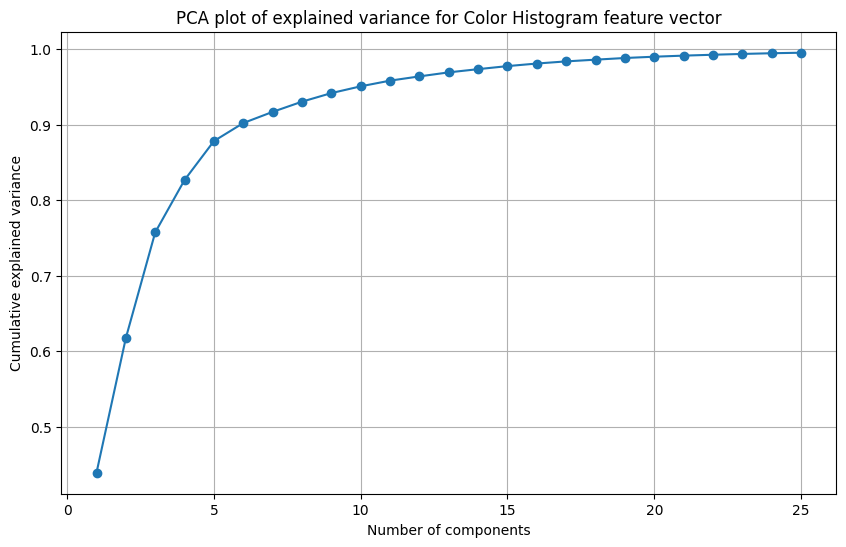

In [39]:
# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for Color Histogram feature vector')
plt.grid(True)
plt.show()

Loaded t-SNE results from pickle\color_hist_tsne.pkl


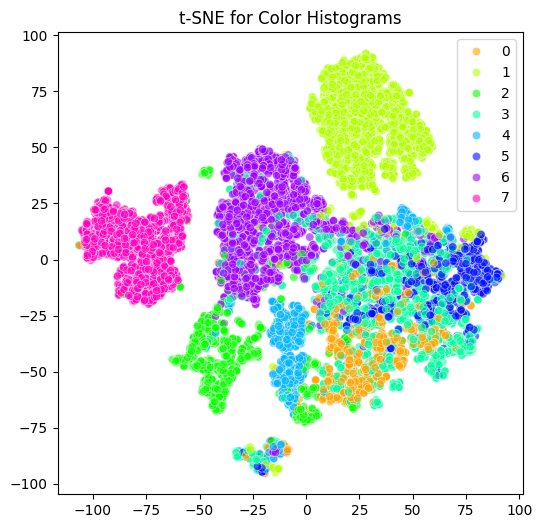

In [40]:
color_hist_tsne = os.path.join(PICKLE_DIR, 'color_hist_tsne.pkl')
perform_tsne_and_pickle(X_train_pca, y_train, title='t-SNE for Color Histograms', pickle_path=color_hist_tsne)

## Histogram of Oriented Gradients and PCA

In [41]:
def extract_hog_features(image):
    # Convert to grayscale
    gray_image = rgb2gray(image)

    features = hog(
        gray_image,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        visualize=False
    )
    return features

In [42]:
# # Run once then comment out and run pickle.load below

# X_train, y_train = create_feature_vectors(train_data_preprocessed, [extract_hog_features])
# X_val, y_val = create_feature_vectors(val_data_preprocessed, [extract_hog_features])
# X_test, y_test = create_feature_vectors(test_data_preprocessed, [extract_hog_features])

# # Save the feature vectors and labels to disk
# with open('pickle/X_train_hog.pkl', 'wb') as f:
#     pickle.dump(X_train, f)
# with open('pickle/y_train_hog.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('pickle/X_val_hog.pkl', 'wb') as f:
#     pickle.dump(X_val, f)
# with open('pickle/y_val_hog.pkl', 'wb') as f:
#     pickle.dump(y_val, f)
# with open('pickle/X_test_hog.pkl', 'wb') as f:
#     pickle.dump(X_test, f)
# with open('pickle/y_test_hog.pkl', 'wb') as f:
#     pickle.dump(y_test, f)


In [43]:
with open('pickle/X_train_hog.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('pickle/y_train_hog.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('pickle/X_val_hog.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('pickle/y_val_hog.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('pickle/X_test_hog.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('pickle/y_test_hog.pkl', 'rb') as f:
    y_test = pickle.load(f)

C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\3159073165.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


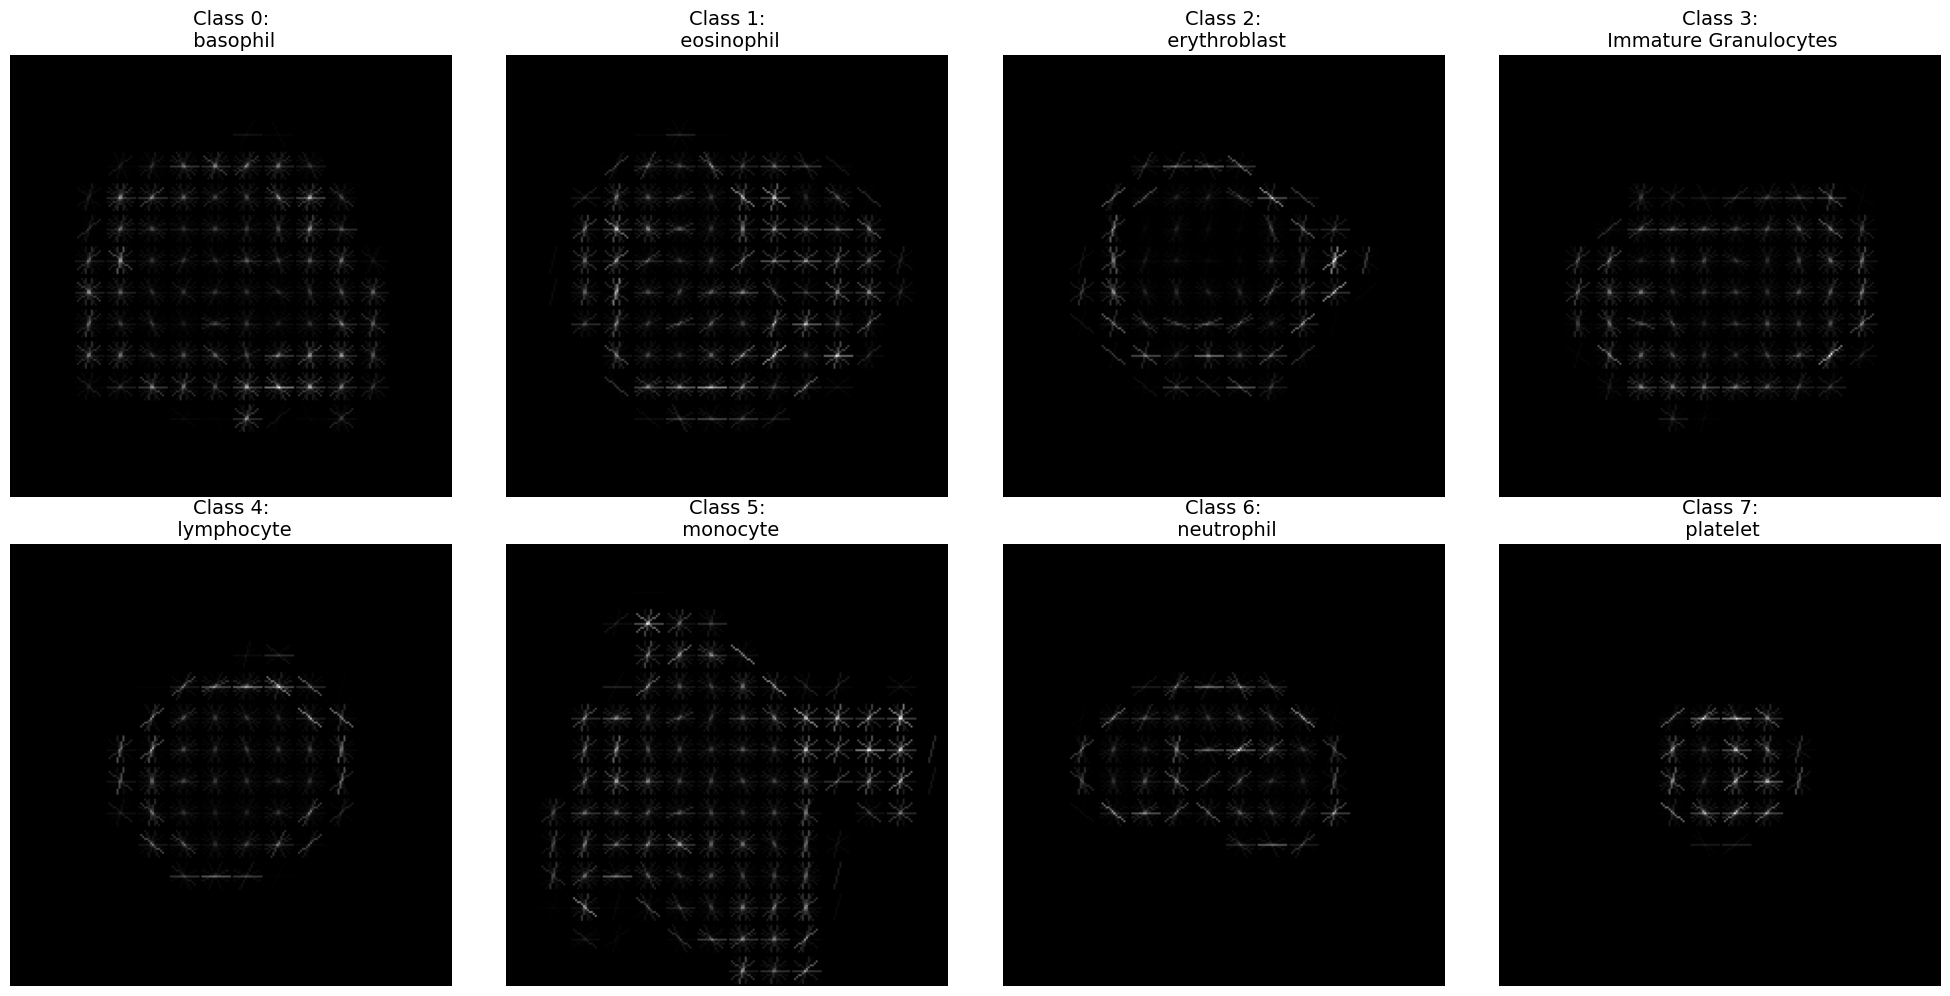

In [44]:
def show_hog_images_by_class(dataset, n_classes, class_labels):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            gray_img = rgb2gray(random_img)
            hog_features, hog_image = hog(gray_img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

            # Plot HOG image
            axes[class_idx].imshow(hog_image, cmap='gray')
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Show HOG images for each class
show_hog_images_by_class(train_data_preprocessed, n_classes_blood, class_labels_blood)

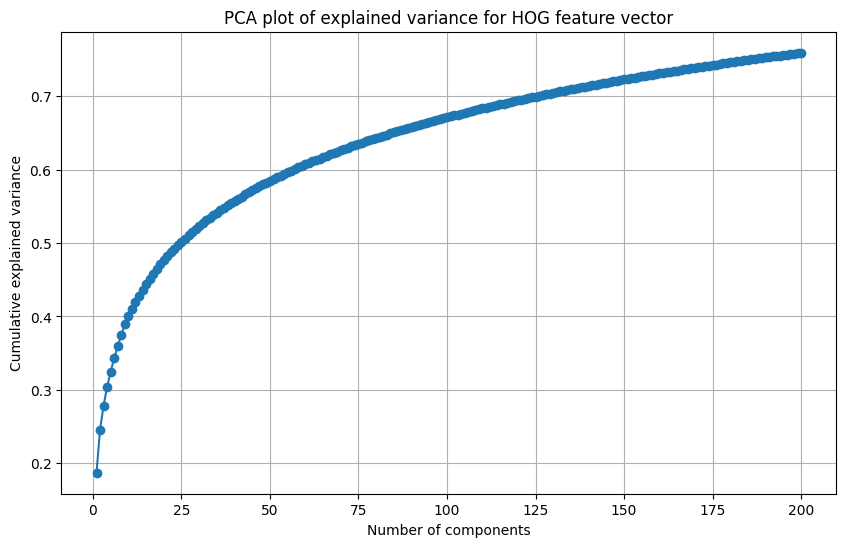

In [45]:
# Apply PCA to reduce dimensionality
n_components = 200 # Adjust based on trade-off between speed and explained variance
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for HOG feature vector')
plt.grid(True)
plt.show()

Loaded t-SNE results from pickle\HOG_tsne.pkl


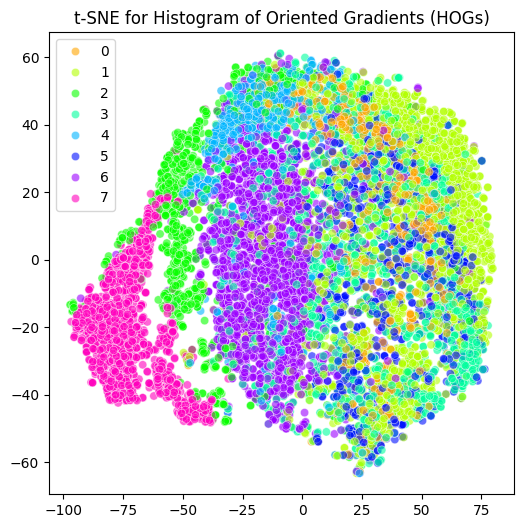

In [46]:
HOG_tsne = os.path.join(PICKLE_DIR, 'HOG_tsne.pkl')
perform_tsne_and_pickle(X_train_pca, y_train, title='t-SNE for Histogram of Oriented Gradients (HOGs)', pickle_path=HOG_tsne)

## GLCM (Gray-Level Co-Occurrence Matrix) and PCA

In [47]:
# Function to extract GLCM features
def extract_glcm_features(image):
    # Ensure the image is 2D (grayscale)
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Compute the GLCM matrix
    distances = [1]  # Define distances for computing GLCM
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Define angles for computing GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Compute GLCM properties
    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    ASM = graycoprops(glcm, 'ASM').flatten()

    features = np.hstack([contrast, dissimilarity, homogeneity, energy, correlation, ASM])
    return features

In [48]:
# # Extract features from the preprocessed datasets using GLCM features
# # Run once then comment out and run pickle.load below
# X_train, y_train = create_feature_vectors(train_data_preprocessed, [extract_glcm_features])
# X_val, y_val = create_feature_vectors(val_data_preprocessed, [extract_glcm_features])
# X_test, y_test = create_feature_vectors(test_data_preprocessed, [extract_glcm_features])

# # Save the feature vectors and labels to disk
# with open('pickle/X_train_glcm.pkl', 'wb') as f:
#     pickle.dump(X_train, f)
# with open('pickle/y_train_glcm.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('pickle/X_val_glcm.pkl', 'wb') as f:
#     pickle.dump(X_val, f)
# with open('pickle/y_val_glcm.pkl', 'wb') as f:
#     pickle.dump(y_val, f)
# with open('pickle/X_test_glcm.pkl', 'wb') as f:
#     pickle.dump(X_test, f)
# with open('pickle/y_test_glcm.pkl', 'wb') as f:
#     pickle.dump(y_test, f)

In [49]:
# Load the feature vectors and labels from disk
with open('pickle/X_train_glcm.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('pickle/y_train_glcm.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('pickle/X_val_glcm.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('pickle/y_val_glcm.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('pickle/X_test_glcm.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('pickle/y_test_glcm.pkl', 'rb') as f:
    y_test = pickle.load(f)

### GLCM features

**1. High dissimilarity** values indicate greater variation between neighboring pixel values, corresponding to a more complex texture. Low dissimilarity values indicate that pixel values are more uniform or similar, corresponding to a smoother texture.

**2. High homogeneity** values indicate that the image has many similar or identical pixel pairs, which correspond to a smooth or uniform texture. Low homogeneity values indicate that the pixel pairs are less similar, corresponding to a more complex texture.

**3. High energy values** indicate that the GLCM has high values for a few gray-level pairs, which means the texture is very uniform

**4. High correlation values** indicate that there is a strong linear relationship between the gray levels of pixel pairs, meaning that the texture has a regular and predictable pattern. Low correlation values indicate a weaker or no linear relationship, corresponding to a more random texture

**5. High ASM values** indicate that the texture is very regular and uniform. Low ASM values indicate a more disordered or complex texture.

C:\Users\Austen\AppData\Local\Temp\ipykernel_3896\3275031396.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features_by_class[int(label)].append(features)


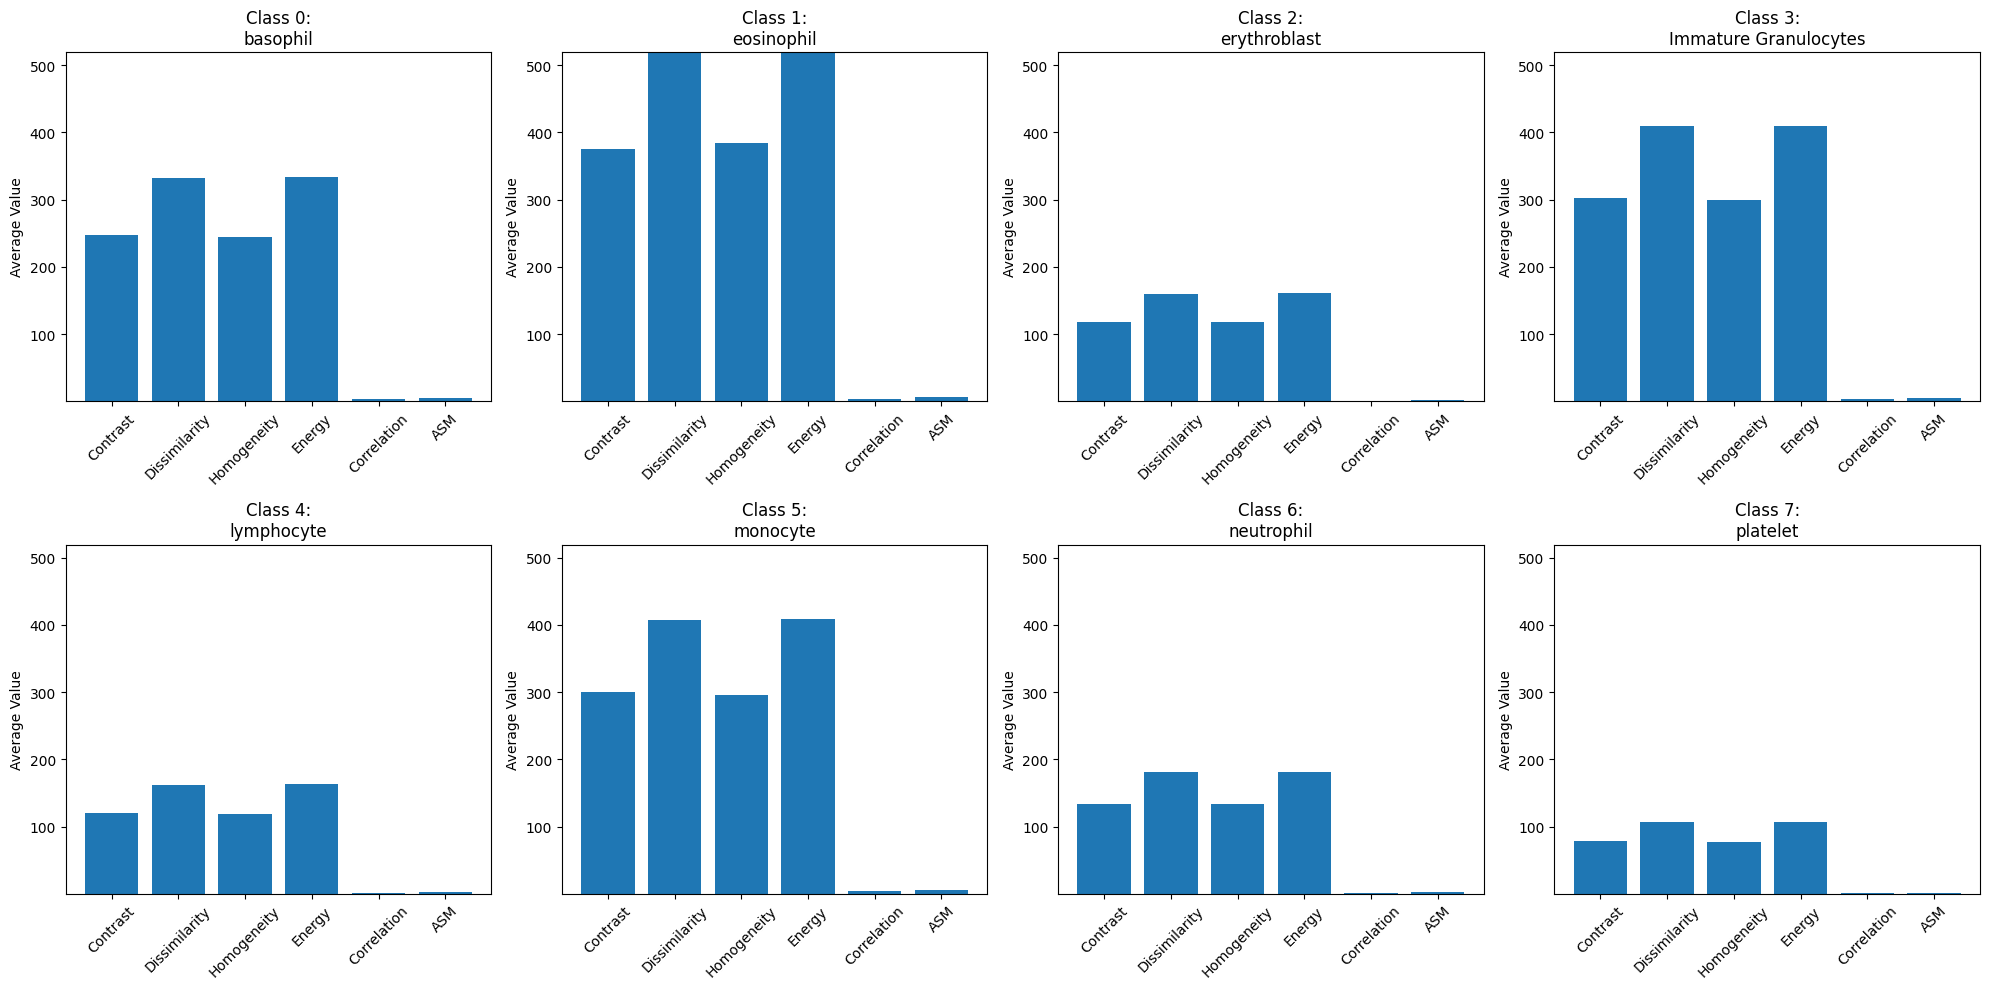

In [50]:
# Function to display GLCM features for each class

def show_glcm_features_by_class(X, y, n_classes, class_labels):
    features_by_class = {i: [] for i in range(n_classes)}

    # Aggregate features by class
    for features, label in zip(X, y):
        features_by_class[int(label)].append(features)

    # Calculate average features for each class
    avg_features_by_class = {class_idx: np.mean(features, axis=0) for class_idx, features in features_by_class.items()}

    # Determine the global min and max values for y-axis
    all_avg_features = np.array(list(avg_features_by_class.values()))
    y_min = np.min(all_avg_features[:, :6])
    y_max = np.max(all_avg_features[:, :6])

    # Plot the average features for each class
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    feature_names = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM']
    for class_idx, avg_features in avg_features_by_class.items():
        axes[class_idx].bar(feature_names, avg_features[:6])
        axes[class_idx].set_title(f"Class {class_idx}:\n{class_labels[str(class_idx)]}")
        axes[class_idx].set_ylim([y_min - 0.1, y_max + 0.1])
        axes[class_idx].set_ylabel('Average Value')
        axes[class_idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Get the class labels and the number of classes
blood_info = INFO['bloodmnist']
class_labels_blood = blood_info['label']
class_labels_blood['3'] = 'Immature Granulocytes'
n_classes_blood = len(class_labels_blood)

# Show GLCM features for each class
show_glcm_features_by_class(X_train, y_train, n_classes_blood, class_labels_blood)

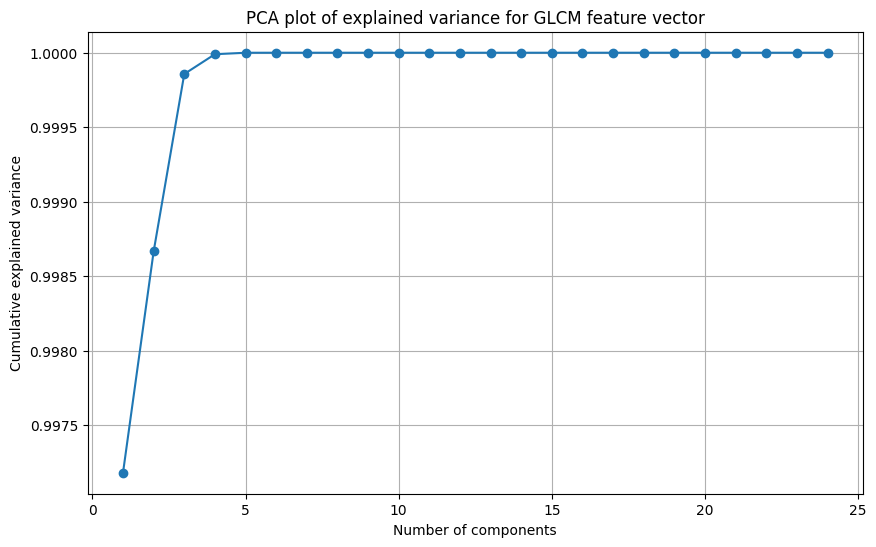

In [51]:
# Apply PCA to reduce dimensionality
n_components = min(X_train.shape[0], X_train.shape[1])  # Set to the minimum of samples and features
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for GLCM feature vector')
plt.grid(True)
plt.show()

Loaded t-SNE results from pickle\GLCM_tsne.pkl


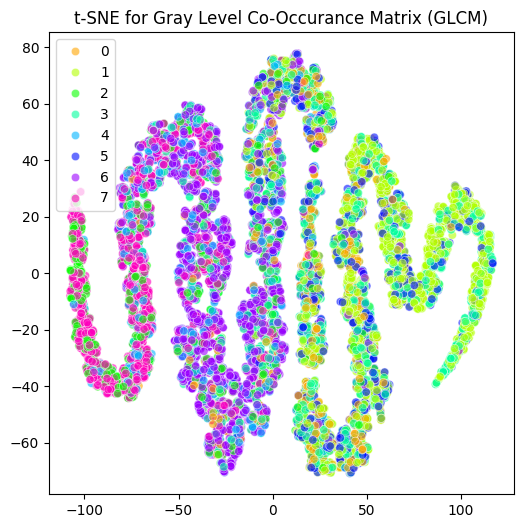

In [52]:
GLCM_tsne = os.path.join(PICKLE_DIR, 'GLCM_tsne.pkl')
perform_tsne_and_pickle(X_train_pca, y_train, title='t-SNE for Gray Level Co-Occurance Matrix (GLCM)', pickle_path=GLCM_tsne)

## Visual Bag of Words and PCA

C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


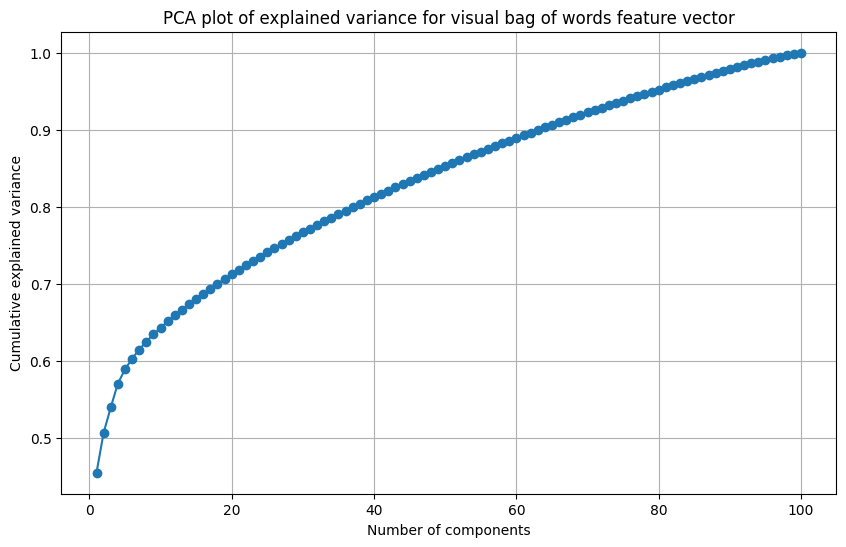

In [53]:
# Directories for pickling
os.makedirs(PICKLE_DIR, exist_ok=True)

# Function to extract SIFT features from an image
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Function to create a visual vocabulary
def create_vocabulary(descriptors_list, vocab_size=100):
    kmeans = MiniBatchKMeans(n_clusters=vocab_size, random_state=0)
    kmeans.fit(descriptors_list)
    return kmeans

# Function to create histograms of visual words for each image
def create_histograms(vocabulary, descriptors_list, vocab_size=100):
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None:
            histogram, _ = np.histogram(vocabulary.predict(descriptors), bins=np.arange(vocab_size+1))
        else:
            histogram = np.zeros(vocab_size)
        histograms.append(histogram)
    return np.array(histograms)

def preprocess_for_bow(dataset):
    descriptors_list = []
    valid_images = []
    labels = []
    for img, label in dataset:
        gray_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
        descriptors = extract_sift_features(gray_img)
        descriptors_list.append(descriptors)
        valid_images.append(img)
        labels.append(label)
    return descriptors_list, valid_images, np.array(labels)

# Load or preprocess the data for BoW
def load_or_preprocess_bow(dataset, pickle_path):
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as f:
            return pickle.load(f)
    else:
        descriptors_list, valid_images, labels = preprocess_for_bow(dataset)
        with open(pickle_path, 'wb') as f:
            pickle.dump((descriptors_list, valid_images, labels), f)
        return descriptors_list, valid_images, labels

# Paths to save the pickled BoW features
train_bow_path = os.path.join(PICKLE_DIR, 'train_bow.pkl')
val_bow_path = os.path.join(PICKLE_DIR, 'val_bow.pkl')
test_bow_path = os.path.join(PICKLE_DIR, 'test_bow.pkl')

# Load or preprocess the data
train_descriptors_list, train_valid_images, y_train = load_or_preprocess_bow(train_data_preprocessed, train_bow_path)
val_descriptors_list, val_valid_images, y_val = load_or_preprocess_bow(val_data_preprocessed, val_bow_path)
test_descriptors_list, test_valid_images, y_test = load_or_preprocess_bow(test_data_preprocessed, test_bow_path)

# Stack all descriptors for vocabulary creation
all_descriptors = np.vstack([desc for desc in train_descriptors_list if desc is not None])

# Create vocabulary
vocab_size = 100
vocabulary = create_vocabulary(all_descriptors, vocab_size=vocab_size)

# Create histograms for each dataset
X_train_bow = create_histograms(vocabulary, train_descriptors_list, vocab_size=vocab_size)
X_val_bow = create_histograms(vocabulary, val_descriptors_list, vocab_size=vocab_size)
X_test_bow = create_histograms(vocabulary, test_descriptors_list, vocab_size=vocab_size)

# Standardize the histograms
scaler = StandardScaler().fit(X_train_bow)
X_train_bow = scaler.transform(X_train_bow)
X_val_bow = scaler.transform(X_val_bow)
X_test_bow = scaler.transform(X_test_bow)

# Paths to save the pickled PCA features
train_pca_bow_path = os.path.join(PICKLE_DIR, 'train_pca_bow.pkl')
val_pca_bow_path = os.path.join(PICKLE_DIR, 'val_pca_bow.pkl')
test_pca_bow_path = os.path.join(PICKLE_DIR, 'test_pca_bow.pkl')

# Apply PCA to reduce dimensionality and pickle the results
def apply_pca_and_pickle(X_train, X_val, X_test, n_components, pca_path_train, pca_path_val, pca_path_test):
    pca = PCA(n_components=n_components)
    if os.path.exists(pca_path_train) and os.path.exists(pca_path_val) and os.path.exists(pca_path_test):
        with open(pca_path_train, 'rb') as f:
            X_train_pca = pickle.load(f)
        with open(pca_path_val, 'rb') as f:
            X_val_pca = pickle.load(f)
        with open(pca_path_test, 'rb') as f:
            X_test_pca = pickle.load(f)
        pca.fit(X_train)  # Fit PCA to the training data to get explained variance ratio
    else:
        n_components = min(n_components, X_train.shape[1])
        X_train_pca = pca.fit_transform(X_train)
        X_val_pca = pca.transform(X_val)
        X_test_pca = pca.transform(X_test)
        with open(pca_path_train, 'wb') as f:
            pickle.dump(X_train_pca, f)
        with open(pca_path_val, 'wb') as f:
            pickle.dump(X_val_pca, f)
        with open(pca_path_test, 'wb') as f:
            pickle.dump(X_test_pca, f)
    return X_train_pca, X_val_pca, X_test_pca, pca

# Apply PCA and save the results
n_components = 100  # Adjust based on trade-off between speed and explained variance
X_train_pca, X_val_pca, X_test_pca, pca = apply_pca_and_pickle(X_train_bow, X_val_bow, X_test_bow, n_components, train_pca_bow_path, val_pca_bow_path, test_pca_bow_path)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for visual bag of words feature vector')
plt.grid(True)
plt.show()

In [54]:
X_train_pca.shape

(11959, 100)

In [55]:
X_train_bow.shape

(11959, 100)

Loaded t-SNE results from pickle\bow_tsne.pkl


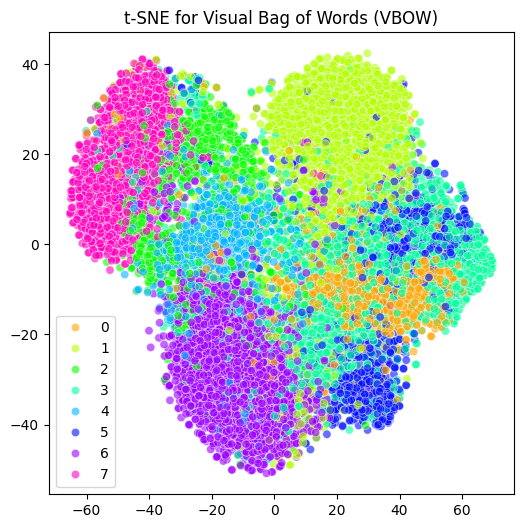

In [56]:
bow_tsne_path = os.path.join(PICKLE_DIR, 'bow_tsne.pkl')
perform_tsne_and_pickle(X_train_pca, y_train, title='t-SNE for Visual Bag of Words (VBOW)', pickle_path=bow_tsne_path)

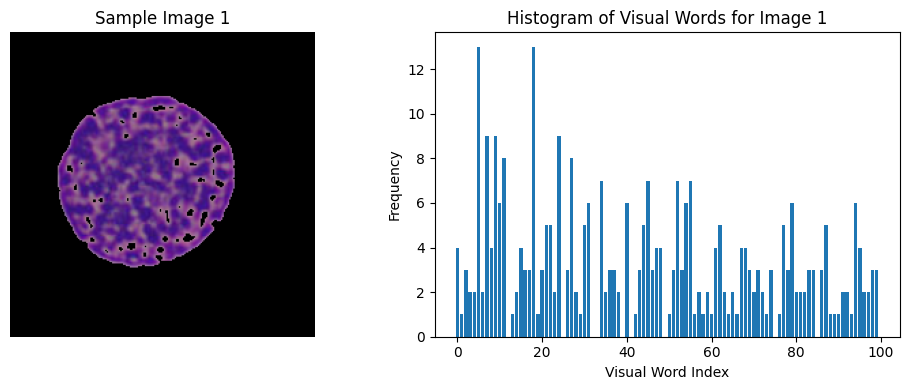

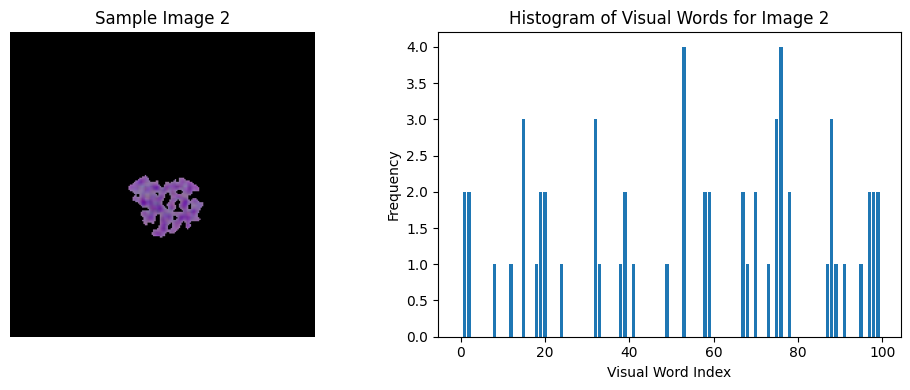

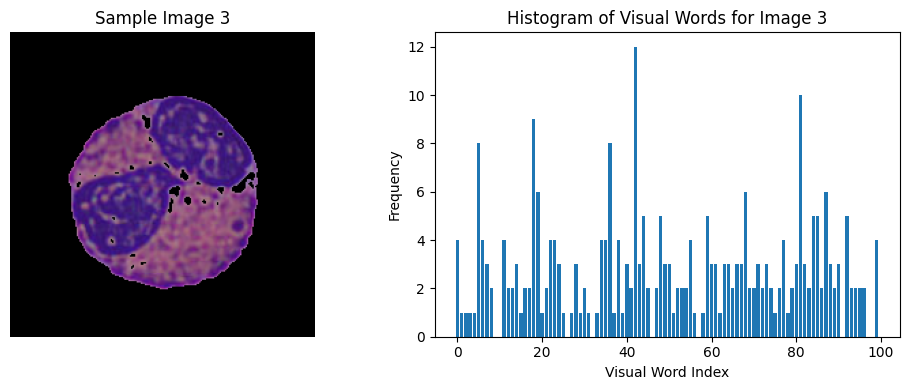

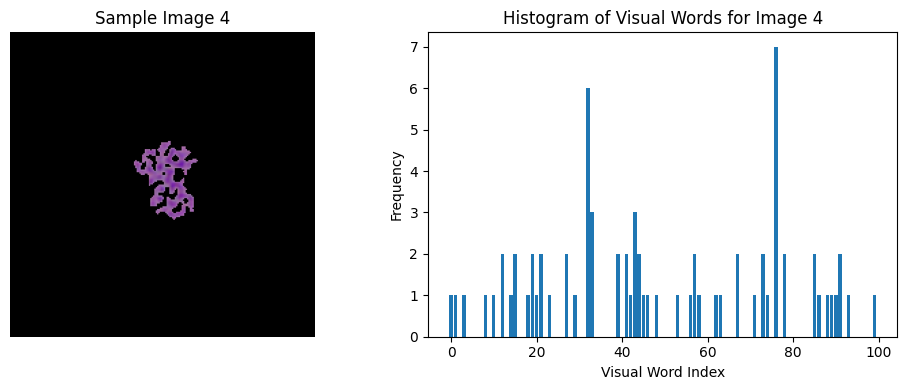

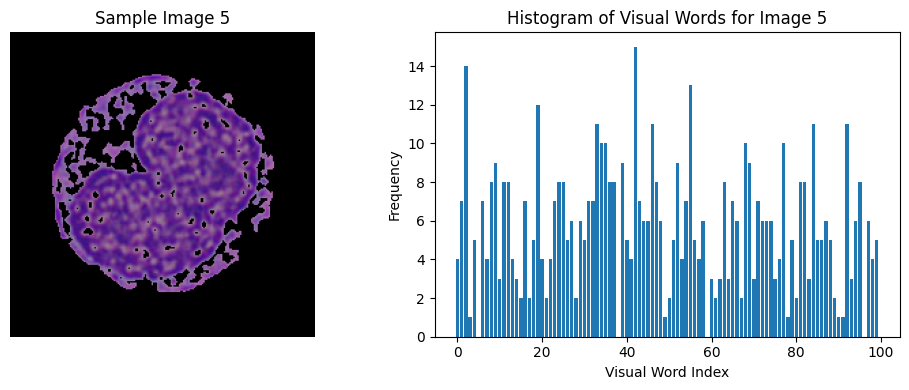

In [57]:
def plot_bow_histograms(vocabulary, descriptors_list, images, n_samples=5):
    """
    Plot histograms of visual words for a few sample images.
    """
    sample_indices = random.sample(range(len(images)), n_samples)
    
    for i, idx in enumerate(sample_indices):
        descriptors = descriptors_list[idx]
        histogram, _ = np.histogram(vocabulary.predict(descriptors), bins=np.arange(vocabulary.n_clusters + 1))
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(images[idx])
        plt.title(f"Sample Image {i + 1}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.bar(range(len(histogram)), histogram)
        plt.title(f"Histogram of Visual Words for Image {i + 1}")
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        
        plt.tight_layout()
        plt.show()

# Plot histograms for a few sample images from the training dataset
plot_bow_histograms(vocabulary, train_descriptors_list, train_valid_images, n_samples=5)


C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


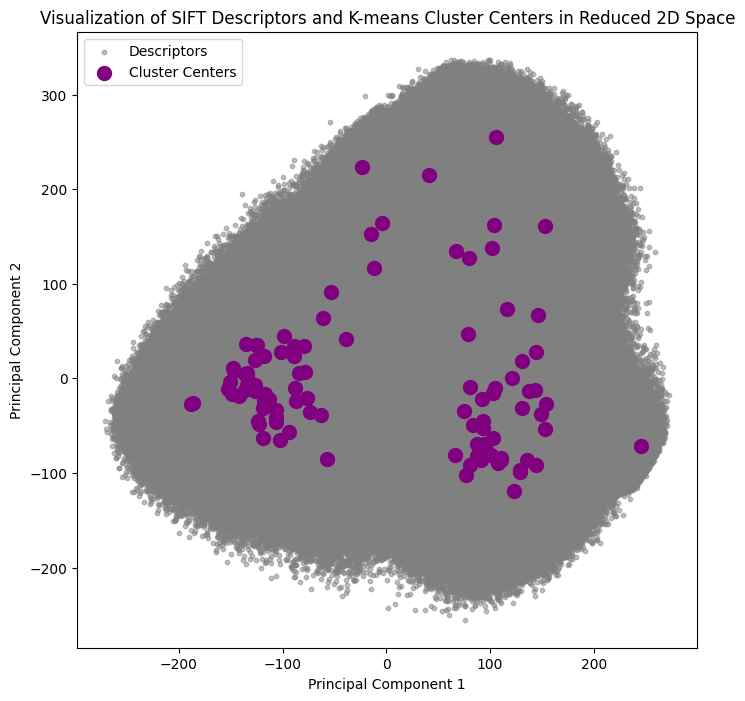

In [58]:
# Reduce dimensionality of descriptors to 2D using PCA
pca = PCA(n_components=2)
reduced_descriptors = pca.fit_transform(all_descriptors)

# Reduce dimensionality of cluster centers (vocabulary) to 2D
reduced_cluster_centers = pca.transform(vocabulary.cluster_centers_)

# Plotting the reduced descriptors and cluster centers
plt.figure(figsize=(8, 8))
plt.scatter(reduced_descriptors[:, 0], reduced_descriptors[:, 1], c='gray', alpha=0.5, s=10, label='Descriptors')
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], c='purple', marker='o', s=100, label='Cluster Centers')
plt.title('Visualization of SIFT Descriptors and K-means Cluster Centers in Reduced 2D Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


# Resnet and PCA

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [60]:
# from tqdm import tqdm

# # Set the device to use for tensor computations
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the ResNet101 model
# resnet101 = models.resnet101(pretrained=True)

# # Function to slice the model and remove the classification layer
# def slice_model(original_model, from_layer=None, to_layer=None):
#     return nn.Sequential(*list(original_model.children())[from_layer:to_layer])

# # Slice the model to remove the classification layer
# model_conv_features = slice_model(resnet101, to_layer=-1).to(device)
# summary(model_conv_features, input_size=(3, 224, 224))

# # Pre-processing required by ResNet
# preprocess = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(224),  # Resize to 224x224
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# def preprocess_image(image):
#     # Convert to grayscale
#     gray = rgb2gray(image)

#     # Apply a binary threshold to segment the target cells
#     _, binary = cv2.threshold((gray * 255).astype(np.uint8), 128, 255, cv2.THRESH_BINARY_INV)

#     # Remove small objects from the binary image
#     cleaned = morphology.remove_small_objects(binary > 0, min_size=500)

#     # Label the connected components
#     labeled, num_labels = measure.label(cleaned, return_num=True, connectivity=2)

#     # Ensure we have a boolean array for `remove_small_objects`
#     largest_component = morphology.remove_small_objects(labeled.astype(bool), min_size=500)

#     # Mask the original image
#     masked_image = image * np.dstack([largest_component > 0] * 3)

#     return masked_image

# # Custom Dataset class to handle preprocessing
# class PreprocessedDataset(Dataset):
#     def __init__(self, data):
#         self.data = data

#     def __getitem__(self, index):
#         img, label = self.data[index]
#         img = preprocess_image(np.array(img))
#         img = preprocess(img)
#         return img, label

#     def __len__(self):
#         return len(self.data)

# train_data_preprocessed = PreprocessedDataset(train_data)
# val_data_preprocessed = PreprocessedDataset(val_data)
# test_data_preprocessed = PreprocessedDataset(test_data)

# # Create DataLoaders for batch processing
# train_loader = DataLoader(train_data_preprocessed, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data_preprocessed, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_data_preprocessed, batch_size=32, shuffle=False)

# # Function to extract features using the sliced ResNet101 model
# def extract_resnet_features(loader, model, device):
#     model.eval()
#     features = []
#     labels = []
#     with torch.no_grad():
#         for imgs, lbls in tqdm(loader, desc="Extracting Features", leave=False):
#             imgs = imgs.to(device)
#             outputs = model(imgs).detach().cpu()  # Detach to prevent tracking gradients
#             features.append(outputs)
#             labels.extend(lbls)
#     return torch.cat(features).numpy(), np.array(labels)

# # Extract features using ResNet
# X_train, y_train = extract_resnet_features(train_loader, model_conv_features, device)
# X_val, y_val = extract_resnet_features(val_loader, model_conv_features, device)
# X_test, y_test = extract_resnet_features(test_loader, model_conv_features, device)

# print("Extracted features shape (train):", X_train.shape)
# print("Labels shape (train):", y_train.shape)
# print("Extracted features shape (val):", X_val.shape)
# print("Labels shape (val):", y_val.shape)
# print("Extracted features shape (test):", X_test.shape)
# print("Labels shape (test):", y_test.shape)

# # Paths to save the pickled features and labels
# train_features_path = os.path.join(PICKLE_DIR, 'X_train_resnet.pkl')
# train_labels_path = os.path.join(PICKLE_DIR, 'y_train_resnet.pkl')
# val_features_path = os.path.join(PICKLE_DIR, 'X_val_resnet.pkl')
# val_labels_path = os.path.join(PICKLE_DIR, 'y_val_resnet.pkl')
# test_features_path = os.path.join(PICKLE_DIR, 'X_test_resnet.pkl')
# test_labels_path = os.path.join(PICKLE_DIR, 'y_test_resnet.pkl')

# # Function to save features and labels to pickle
# def save_to_pickle(data, path):
#     with open(path, 'wb') as f:
#         pickle.dump(data, f)

# # Save the features and labels
# save_to_pickle(X_train, train_features_path)
# save_to_pickle(y_train, train_labels_path)
# save_to_pickle(X_val, val_features_path)
# save_to_pickle(y_val, val_labels_path)
# save_to_pickle(X_test, test_features_path)
# save_to_pickle(y_test, test_labels_path)

# print("Features and labels have been saved to pickle files.")

In [61]:
# Function to load features and labels from pickle
def load_from_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Load the features and labels
X_train_resnet = load_from_pickle('pickle/X_train_resnet.pkl')
y_train_resnet = load_from_pickle('pickle/y_train_resnet.pkl')
X_val_resnet = load_from_pickle('pickle/X_val_resnet.pkl')
y_val_resnet = load_from_pickle('pickle/y_val_resnet.pkl')
X_test_resnet = load_from_pickle('pickle/X_test_resnet.pkl')
y_test_resnet = load_from_pickle('pickle/y_test_resnet.pkl')

print("Features and labels have been loaded from pickle files.")

Features and labels have been loaded from pickle files.


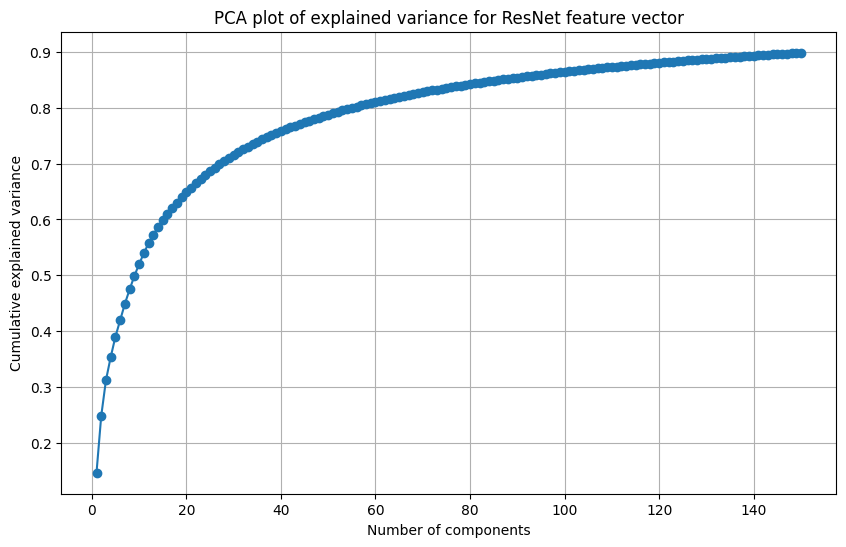

In [62]:
# Reshape the data to 2D
X_train_reshaped = X_train_resnet.reshape(X_train_resnet.shape[0], -1)
X_val_reshaped = X_val_resnet.reshape(X_val_resnet.shape[0], -1)
X_test_reshaped = X_test_resnet.reshape(X_test_resnet.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Apply PCA
n_components = 150
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for ResNet feature vector')
plt.grid(True)
plt.show()


# Define Final Feature Vector

In [63]:
def create_feature_vectors(dataset, feature_extractors, resnet_features, bow_features, additional_features=None):
    feature_vectors = []
    labels = []
    for i, (img, label) in enumerate(dataset):
        features = []
        for extractor in feature_extractors:
            features.extend(extractor(np.array(img)))
        if resnet_features is not None:
            features.extend(resnet_features[i].flatten().tolist())
        if bow_features is not None:
            if isinstance(bow_features[i], np.ndarray):
                features.extend(bow_features[i].tolist())
            else:
                features.extend(np.zeros(vocab_size).tolist())  # Add zero vector for missing BoW
        if additional_features is not None:
            features.append(additional_features[i])
        feature_vectors.append(features)
        labels.append(label)
    return np.array(feature_vectors), np.array(labels)

# Handle infinity or very large values in the dataset
def handle_infinite_values(X):
    finite_mean = np.nanmean(X[np.isfinite(X)])
    X = np.nan_to_num(X, nan=finite_mean, posinf=finite_mean, neginf=finite_mean)
    return X

In [64]:
# Exclude HOG and Resnet

X_train, y_train = create_feature_vectors(train_data_preprocessed, [
    extract_color_histogram,
    # extract_hog_features,
    extract_glcm_features
], 
    # X_train_resnet,
    X_train_bow,
    stain_counts_df['light_to_dark_ratio'].values[:len(train_data_preprocessed)])

X_val, y_val = create_feature_vectors(val_data_preprocessed, [
    extract_color_histogram,
    # extract_hog_features,
    extract_glcm_features
], 
    # X_val_resnet,
    X_val_bow,
    stain_counts_df['light_to_dark_ratio'].values[len(train_data_preprocessed):len(train_data_preprocessed) + len(val_data_preprocessed)])

X_test, y_test = create_feature_vectors(test_data_preprocessed, [
    extract_color_histogram,
    # extract_hog_features,
    extract_glcm_features
], 
    # X_test_resnet,
    X_test_bow,
    stain_counts_df['light_to_dark_ratio'].values[len(train_data_preprocessed) + len(val_data_preprocessed):])

In [65]:
# Handle infinity or very large values
X_train = handle_infinite_values(X_train)
X_val = handle_infinite_values(X_val)
X_test = handle_infinite_values(X_test)

# Standardize the final feature vectors
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [66]:
print(f"X-Train Shape: {X_train.shape}")
print(f"X-Val Shape: {X_val.shape}")
print(f"X-Test Shape: {X_test.shape}")

X-Train Shape: (11959, 736)
X-Val Shape: (1712, 736)
X-Test Shape: (3421, 736)


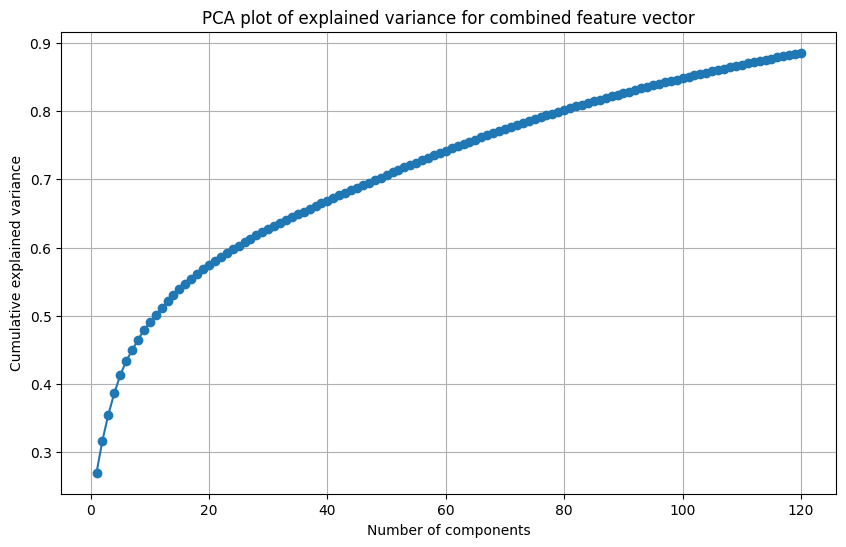

In [67]:
# Apply PCA to reduce dimensionality
n_components =120  # Adjust based on trade-off between speed and explained variance
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for combined feature vector')
plt.grid(True)
plt.show()

Loaded t-SNE results from pickle\final_tsne.pkl


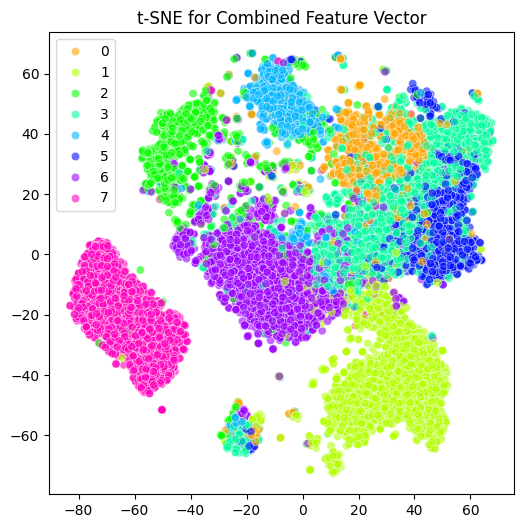

In [68]:
final_tsne_path = os.path.join(PICKLE_DIR, 'final_tsne.pkl')
perform_tsne_and_pickle(X_train_pca, y_train, title='t-SNE for Combined Feature Vector', pickle_path=final_tsne_path)

# Build and Evaluate Models

In [69]:
def plot_confusion_matrix(y_true, y_pred, classes, title, cmap='Blues'):
    '''Function is used for plotting '''
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


## Logistic Regression (Baseline)

C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

Best parameters: {'max_iter': 500}
Best accuracy: 0.91638
Search time: 13.4661 seconds


C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: 0.9714 seconds 

Training prediction time: 0.0020 seconds
Validation prediction time: 0.0000 seconds
Test prediction time: 0.0010 seconds 

Training accuracy: 0.9431390584497031
Validation accuracy: 0.9281542056074766
Test accuracy: 0.9201987722888044 

Classification report (Test):
                       precision    recall  f1-score   support

             basophil       0.89      0.90      0.90       244
           eosinophil       0.97      0.98      0.98       624
         erythroblast       0.94      0.93      0.93       311
Immature Granulocytes       0.84      0.82      0.83       579
           lymphocyte       0.92      0.93      0.93       243
             monocyte       0.81      0.81      0.81       284
           neutrophil       0.94      0.95      0.94       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.92      3421
            macro avg       0.91      0.91      0.91      3421
      

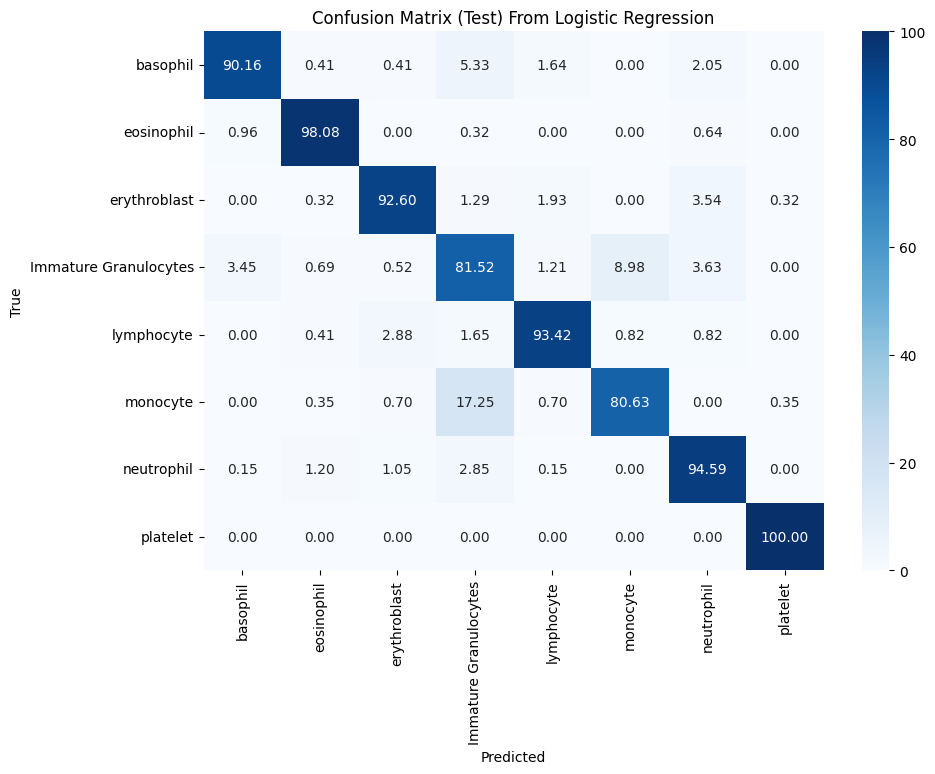

In [70]:
# Define parameter grid
param_grid = {'max_iter': [100, 500, 1000, 2000]}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

# Fit to the data
start_time = time.time()
grid_search.fit(X_train_pca, y_train)
search_time = time.time() - start_time

# Get best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.5f}")
print(f"Search time: {search_time:.4f} seconds")

# Train logistic regression model with best parameters and measure training time
start_time = time.time()
log_reg = LogisticRegression(max_iter=best_params['max_iter'])
log_reg.fit(X_train_pca, y_train)
train_time = time.time() - start_time

# Measure prediction time for train set
start_time = time.time()
y_train_pred = log_reg.predict(X_train_pca)
train_pred_time = time.time() - start_time

# Measure prediction time for validation set
start_time = time.time()
y_val_pred = log_reg.predict(X_val_pca)
val_pred_time = time.time() - start_time

# Measure prediction time for test set
start_time = time.time()
y_test_pred = log_reg.predict(X_test_pca)
test_pred_time = time.time() - start_time

print("Training time: {:.4f} seconds".format(train_time), '\n')
print("Training prediction time: {:.4f} seconds".format(train_pred_time))
print("Validation prediction time: {:.4f} seconds".format(val_pred_time))
print("Test prediction time: {:.4f} seconds".format(test_pred_time), '\n')

print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred), '\n')
print("Classification report (Test):")
print(classification_report(y_test, y_test_pred, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

# Plot confusion matrix for test data
plot_confusion_matrix(y_test, y_test_pred, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Confusion Matrix (Test) From Logistic Regression')


## Random Forest

C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

Best parameters: {'max_depth': 10, 'n_estimators': 200}
Best accuracy: 0.89355
Search time: 384.8042 seconds


C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Random Forest:
Training time: 16.0534 seconds 

Training prediction time: 0.1600 seconds
Validation prediction time: 0.0360 seconds
Test prediction time: 0.0590 seconds 

Training accuracy: 0.9684756250522619
Validation accuracy: 0.9223130841121495
Test accuracy: 0.904121601870798 

Classification report (Test):
                       precision    recall  f1-score   support

             basophil       0.92      0.77      0.84       244
           eosinophil       0.99      0.96      0.97       624
         erythroblast       0.95      0.87      0.91       311
Immature Granulocytes       0.73      0.89      0.80       579
           lymphocyte       0.96      0.90      0.93       243
             monocyte       0.88      0.71      0.79       284
           neutrophil       0.91      0.95      0.93       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.90      3421
            macro avg       0.92      0.88      0.90 

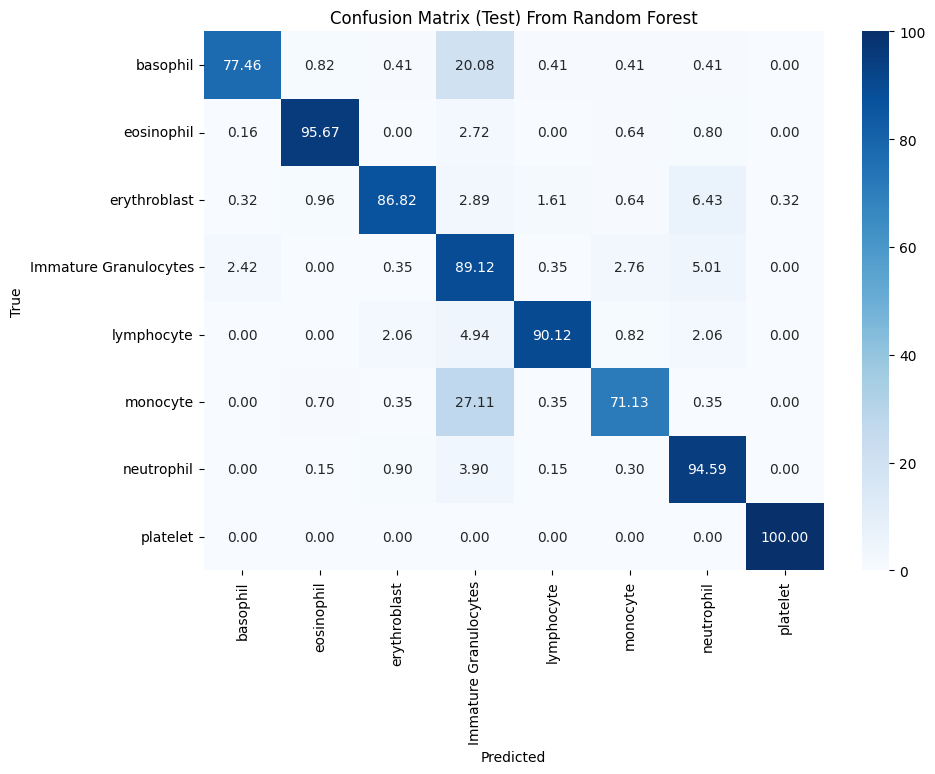

In [71]:
# Define parameter grid
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'n_estimators': [10, 50, 100, 200]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')

# Fit to the data
start_time = time.time()
grid_search.fit(X_train_pca, y_train)
search_time = time.time() - start_time

# Get best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.5f}")
print(f"Search time: {search_time:.4f} seconds")

# Train Random Forest model with best parameters and measure training time
start_time = time.time()
rf_model = RandomForestClassifier(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], random_state=42)
rf_model.fit(X_train_pca, y_train)
train_time = time.time() - start_time

# Measure prediction time for train set
start_time = time.time()
y_train_pred = rf_model.predict(X_train_pca)
train_pred_time = time.time() - start_time

# Measure prediction time for validation set
start_time = time.time()
y_val_pred = rf_model.predict(X_val_pca)
val_pred_time = time.time() - start_time

# Measure prediction time for test set
start_time = time.time()
y_test_pred = rf_model.predict(X_test_pca)
test_pred_time = time.time() - start_time

print("\nRandom Forest:")
print("Training time: {:.4f} seconds".format(train_time), '\n')
print("Training prediction time: {:.4f} seconds".format(train_pred_time))
print("Validation prediction time: {:.4f} seconds".format(val_pred_time))
print("Test prediction time: {:.4f} seconds".format(test_pred_time), '\n')

print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred), '\n')
print("Classification report (Test):")
print(classification_report(y_test, y_test_pred, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

# Plot confusion matrix for test data
plot_confusion_matrix(y_test, y_test_pred, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Confusion Matrix (Test) From Random Forest')


## XGBoost

C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\A

Best parameters: {'max_depth': 4, 'n_estimators': 200}
Best accuracy: 0.92784
Search time: 258.4178 seconds


C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost:
Training time: 3.9581 seconds 

Training prediction time: 0.0510 seconds
Validation prediction time: 0.0070 seconds
Test prediction time: 0.0170 seconds 

Training accuracy: 0.9999163809683084
Validation accuracy: 0.9415887850467289
Test accuracy: 0.9459222449576147 

Classification report (Test):
                       precision    recall  f1-score   support

             basophil       0.93      0.92      0.93       244
           eosinophil       0.99      0.99      0.99       624
         erythroblast       0.96      0.93      0.94       311
Immature Granulocytes       0.87      0.90      0.88       579
           lymphocyte       0.97      0.96      0.96       243
             monocyte       0.91      0.88      0.89       284
           neutrophil       0.94      0.95      0.95       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.95      3421
            macro avg       0.95      0.94      0.94      3

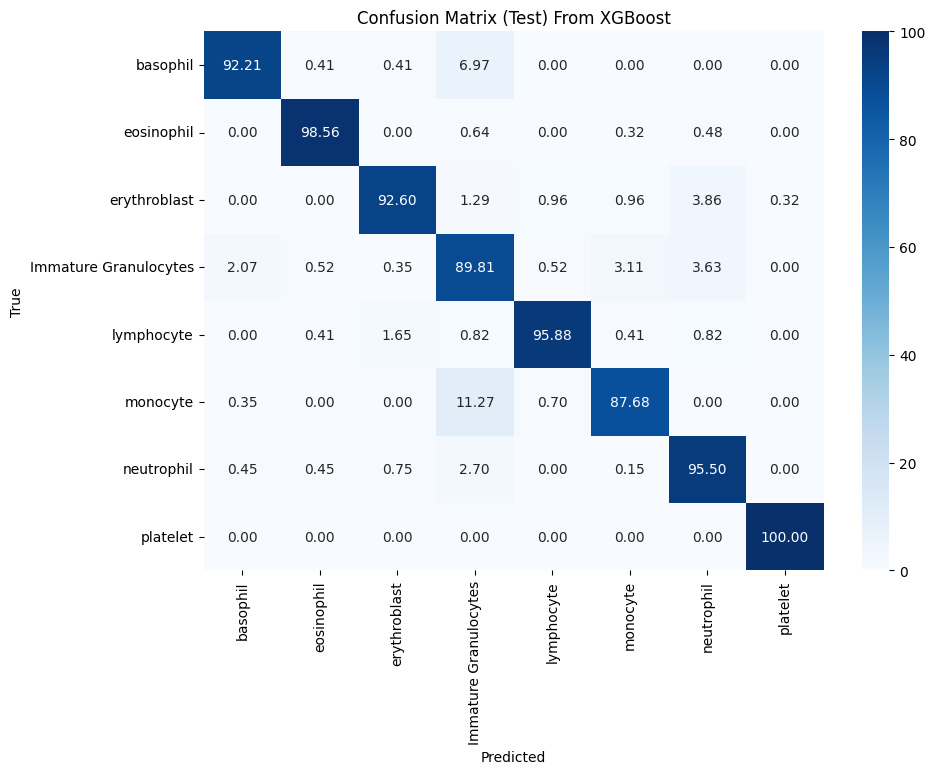

In [72]:
# Define parameter grid
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'n_estimators': [10, 50, 100, 200]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), param_grid, cv=5, scoring='accuracy')

# Fit to the data
start_time = time.time()
grid_search.fit(X_train_pca, y_train)
search_time = time.time() - start_time

# Get best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.5f}")
print(f"Search time: {search_time:.4f} seconds")

# Train XGBoost model with best parameters and measure training time
start_time = time.time()
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'])
xgb_model.fit(X_train_pca, y_train)
train_time = time.time() - start_time

# Measure prediction time for train set
start_time = time.time()
y_train_pred = xgb_model.predict(X_train_pca)
train_pred_time = time.time() - start_time

# Measure prediction time for validation set
start_time = time.time()
y_val_pred = xgb_model.predict(X_val_pca)
val_pred_time = time.time() - start_time

# Measure prediction time for test set
start_time = time.time()
y_test_pred = xgb_model.predict(X_test_pca)
test_pred_time = time.time() - start_time

print("\nXGBoost:")
print("Training time: {:.4f} seconds".format(train_time), '\n')
print("Training prediction time: {:.4f} seconds".format(train_pred_time))
print("Validation prediction time: {:.4f} seconds".format(val_pred_time))
print("Test prediction time: {:.4f} seconds".format(test_pred_time), '\n')

print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred), '\n')
print("Classification report (Test):")
print(classification_report(y_test, y_test_pred, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

# Plot confusion matrix for test data
plot_confusion_matrix(y_test, y_test_pred, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Confusion Matrix (Test) From XGBoost')


## Support Vector Machines

### SVM (Linear)

C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  w

Best parameters: {'C': 1}
Best accuracy: 0.85233
Search time: 13.2017 seconds


C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Linear SVM:
Training time: 0.6842 seconds 

Training prediction time: 0.7462 seconds
Validation prediction time: 0.1080 seconds
Test prediction time: 0.2140 seconds 

Training accuracy: 0.8866125930261728
Validation accuracy: 0.8703271028037384
Test accuracy: 0.867874890382929 

Classification report (Test):
                       precision    recall  f1-score   support

             basophil       0.80      0.81      0.80       244
           eosinophil       0.94      0.98      0.96       624
         erythroblast       0.90      0.94      0.92       311
Immature Granulocytes       0.72      0.59      0.65       579
           lymphocyte       0.94      0.93      0.93       243
             monocyte       0.69      0.75      0.72       284
           neutrophil       0.87      0.93      0.90       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.87      3421
            macro avg       0.86      0.87      0.86     

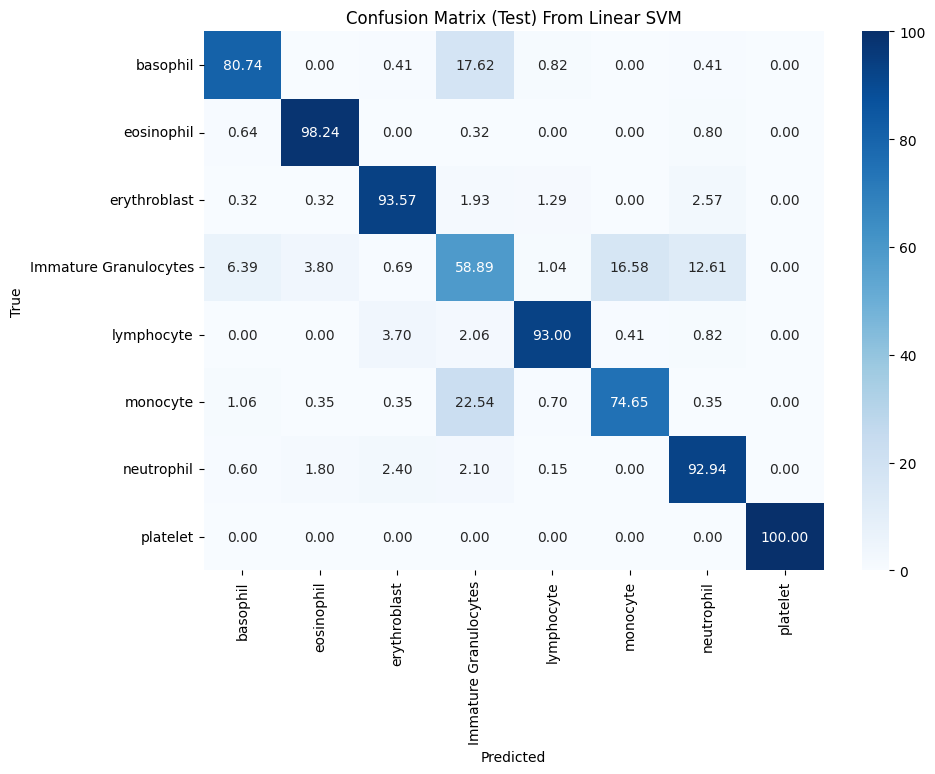

In [73]:
# Define parameter grid
param_grid = {
    'C': [1, 2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(SVC(kernel='linear', max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Fit to the data
start_time = time.time()
grid_search.fit(X_train_pca, y_train)
search_time = time.time() - start_time

# Get best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.5f}")
print(f"Search time: {search_time:.4f} seconds")

# Train and evaluate linear SVM model with best parameters and measure training time
start_time = time.time()
linear_svm = SVC(kernel='linear', max_iter=1000, C=best_params['C'])
linear_svm.fit(X_train_pca, y_train)
train_time = time.time() - start_time

# Measure prediction time for train set
start_time = time.time()
y_train_pred_linear = linear_svm.predict(X_train_pca)
train_pred_time = time.time() - start_time

# Measure prediction time for validation set
start_time = time.time()
y_val_pred_linear = linear_svm.predict(X_val_pca)
val_pred_time = time.time() - start_time

# Measure prediction time for test set
start_time = time.time()
y_test_pred_linear = linear_svm.predict(X_test_pca)
test_pred_time = time.time() - start_time

print("\nLinear SVM:")
print("Training time: {:.4f} seconds".format(train_time), '\n')
print("Training prediction time: {:.4f} seconds".format(train_pred_time))
print("Validation prediction time: {:.4f} seconds".format(val_pred_time))
print("Test prediction time: {:.4f} seconds".format(test_pred_time), '\n')

print("Training accuracy:", accuracy_score(y_train, y_train_pred_linear))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred_linear))
print("Test accuracy:", accuracy_score(y_test, y_test_pred_linear), '\n')
print("Classification report (Test):")
print(classification_report(y_test, y_test_pred_linear, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

# Plot confusion matrix for test data
plot_confusion_matrix(y_test, y_test_pred_linear, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Confusion Matrix (Test) From Linear SVM')


### SVM (RBF - Radian Basis Function)

C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  w

Best parameters: {'C': 10}
Best accuracy: 0.93453
Search time: 31.0529 seconds


C:\Users\Austen\anaconda3\envs\MIDS\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



RBF SVM:
Training time: 1.2533 seconds 

Training prediction time: 3.1686 seconds
Validation prediction time: 0.4491 seconds
Test prediction time: 0.8988 seconds 

Training accuracy: 0.984864955263818
Validation accuracy: 0.947429906542056
Test accuracy: 0.9482607424729611 

Classification report (Test):
                       precision    recall  f1-score   support

             basophil       0.91      0.93      0.92       244
           eosinophil       0.99      0.97      0.98       624
         erythroblast       0.88      0.95      0.92       311
Immature Granulocytes       0.90      0.90      0.90       579
           lymphocyte       0.96      0.95      0.96       243
             monocyte       0.94      0.90      0.92       284
           neutrophil       0.96      0.95      0.95       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.95      3421
            macro avg       0.94      0.95      0.94      342

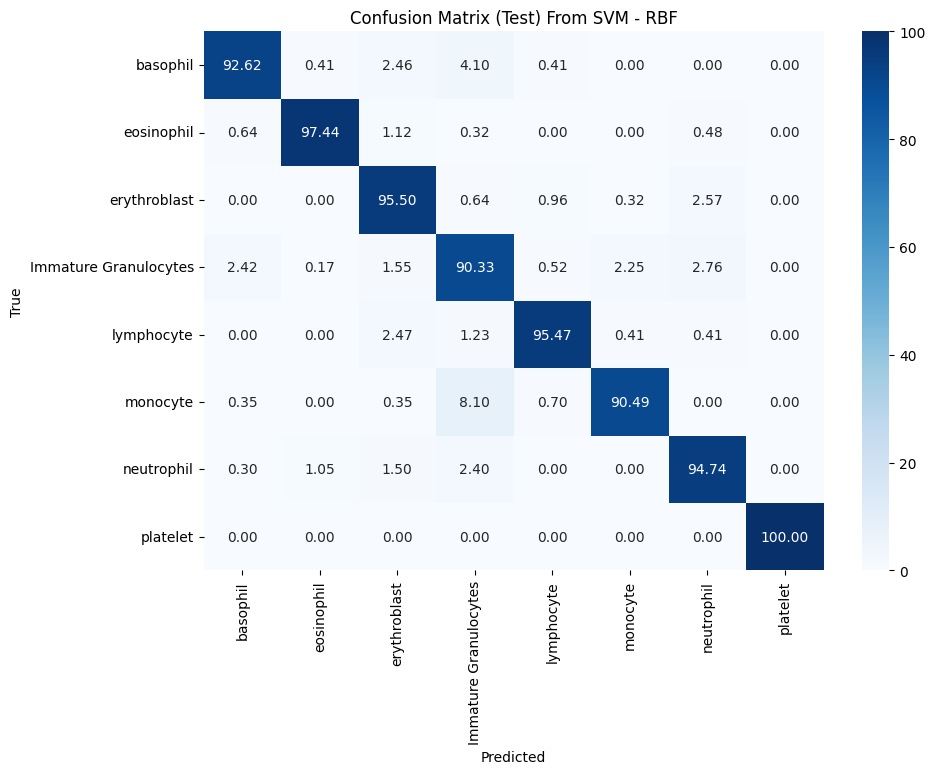

In [74]:
# Define parameter grid
param_grid = {
    'C': [1, 2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(SVC(kernel='rbf', max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Fit to the data
start_time = time.time()
grid_search.fit(X_train_pca, y_train)
search_time = time.time() - start_time

# Get best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.5f}")
print(f"Search time: {search_time:.4f} seconds")

# Train and evaluate RBF SVM model with best parameters and measure training time
start_time = time.time()
rbf_svm = SVC(kernel='rbf', max_iter=1000, C=best_params['C'])
rbf_svm.fit(X_train_pca, y_train)
train_time = time.time() - start_time

# Measure prediction time for train set
start_time = time.time()
y_train_pred_rbf = rbf_svm.predict(X_train_pca)
train_pred_time = time.time() - start_time

# Measure prediction time for validation set
start_time = time.time()
y_val_pred_rbf = rbf_svm.predict(X_val_pca)
val_pred_time = time.time() - start_time

# Measure prediction time for test set
start_time = time.time()
y_test_pred_rbf = rbf_svm.predict(X_test_pca)
test_pred_time = time.time() - start_time

print("\nRBF SVM:")
print("Training time: {:.4f} seconds".format(train_time), '\n')
print("Training prediction time: {:.4f} seconds".format(train_pred_time))
print("Validation prediction time: {:.4f} seconds".format(val_pred_time))
print("Test prediction time: {:.4f} seconds".format(test_pred_time), '\n')

print("Training accuracy:", accuracy_score(y_train, y_train_pred_rbf))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred_rbf))
print("Test accuracy:", accuracy_score(y_test, y_test_pred_rbf), '\n')
print("Classification report (Test):")
print(classification_report(y_test, y_test_pred_rbf, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

# Plot confusion matrix for test data
plot_confusion_matrix(y_test, y_test_pred_rbf, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Confusion Matrix (Test) From SVM - RBF')
